In [1]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from matplotlib.ticker import MultipleLocator
import nibabel as nib
import pickle

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

print(sys.path)
%pwd

['/home/rfpred/notebooks', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode']


'/home/rfpred'

In [2]:
from funcs.imgproc import get_imgs_designmx, rms_all, feature_df, show_stim, get_rms_contrast, get_rms_contrast_lab, get_contrast_df, get_img_prf, get_visfeature_dict
from funcs.rf_tools import get_mask, css_gaussian_cut, make_circle_mask, make_visrois_dict, write_prf_dict
from funcs.utility import print_dict_structure, print_large, get_zscore, mean_center, hypotheses_plot, multiple_regression
from funcs.analyses import multivariate_regression, regression_dict_multivariate, plot_roi_beta_distribution, get_hrf_dict, plot_beta_to_icept, reg_plots
from funcs.utility import numpy2coords, coords2numpy, filter_array_by_size, find_common_rows
# from funcs.viscontrasts import lgn_statistics
from notebooks.alien_nbs.lgnpy.lgnpy.CEandSC import lgn_statistics

In [3]:
n_subjects = len(os.listdir('/home/rfpred/data/natural-scenes-dataset/nsddata/ppdata'))
vismask_dict = make_visrois_dict(vox_count = 'y', bin_check = 'n', n_subjects=n_subjects)
prf_dict = write_prf_dict(binary_masks = vismask_dict)

Subject 1
V1_mask
Non-zero voxels in V1_mask: 7887
V2_mask
Non-zero voxels in V2_mask: 8296
V3_mask
Non-zero voxels in V3_mask: 7022
V4_mask
Non-zero voxels in V4_mask: 3976
Subject 2
V1_mask
Non-zero voxels in V1_mask: 6476
V2_mask
Non-zero voxels in V2_mask: 6376
V3_mask
Non-zero voxels in V3_mask: 6236
V4_mask
Non-zero voxels in V4_mask: 2887
Subject 3
V1_mask
Non-zero voxels in V1_mask: 7358
V2_mask
Non-zero voxels in V2_mask: 6721
V3_mask
Non-zero voxels in V3_mask: 5316
V4_mask
Non-zero voxels in V4_mask: 2486
Subject 4
V1_mask
Non-zero voxels in V1_mask: 5119
V2_mask
Non-zero voxels in V2_mask: 5088
V3_mask
Non-zero voxels in V3_mask: 4669
V4_mask
Non-zero voxels in V4_mask: 2790
Subject 5
V1_mask
Non-zero voxels in V1_mask: 6502
V2_mask
Non-zero voxels in V2_mask: 6309
V3_mask
Non-zero voxels in V3_mask: 5383
V4_mask
Non-zero voxels in V4_mask: 3184
Subject 6
V1_mask
Non-zero voxels in V1_mask: 6479
V2_mask
Non-zero voxels in V2_mask: 6905
V3_mask
Non-zero voxels in V3_mask: 71

Load in the visual contrast features (currently only rms)

In [4]:
with open('./data/custom_files/all_visfeats_rms.pkl', 'rb') as fp:
   visfeats_rms = pickle.load(fp)

In [5]:
visfeats_rms['subj01']['rms']

img_no        rms     rms_z     rms_mc
0       46002  25.471033 -0.060673  -0.743838
1       61882  22.462335 -0.306086  -3.752536
2         828  18.877597 -0.598484  -7.337274
3       67573  42.634550  1.339314  16.419679
4       16020  16.612092 -0.783276  -9.602780
...       ...        ...       ...        ...
29995   13773  22.456342 -0.306574  -3.758529
29996   66767   8.632073 -1.434187 -17.582798
29997   53167  27.830569  0.131789   1.615698
29998    1943  20.272697 -0.484689  -5.942174
29999    5033   8.638144 -1.433692 -17.576727

[30000 rows x 4 columns]

Load in the pRF based voxel selection masks. Important to notice is that these masks are different form the voxmasks created using the get_hrf_dict function, as those filter out even more voxels based on newly included restrictions. Thus, the prf_masks are more liberal than the voxmasks. The reason for this is because it allows us to do some precise voxel selection of an intitial relatively rough selection, without having to retrieve a completely new mask. 

In [6]:

# Load in the saved masks for selected voxels that have their prf inside the inner patch.
with open('./data/custom_files/subj01/prf_mask_center_strict.pkl', 'rb') as fp:
    prf_mask_center_strict = pickle.load(fp)
    
    
with open('./data/custom_files/subj01/prf_mask_central_loose.pkl', 'rb') as fp:
    prf_mask_central_loose = pickle.load(fp) 
    

# Load in the saved file
with open('./data/custom_files/subj01/prf_mask_periphery_strict.pkl', 'rb') as fp:
   prf_mask_periphery_strict = pickle.load(fp)


# Load in the saved file
with open('./data/custom_files/subj01/new_prf_mask_central_strict.pkl', 'rb') as fp:
   new_central_mask = pickle.load(fp)

Load in the HRF signal dictionaries for different voxel selections

beta_dict0_2.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 2250
beta_dict3_5.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 4500
beta_dict6_10.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 8250
beta_dict11_15.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 12000
beta_dict16_20.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 15750
beta_dict21_27.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 21000
beta_dict28_35.pkl
	Amount of voxels: 98
	Amount of voxels: 171
	Amount of voxels: 156
	Amount of voxels: 223
	Processed images: 27000
beta_dict36_39.pkl
	Amount of voxels: 98
	Amount of voxels: 171

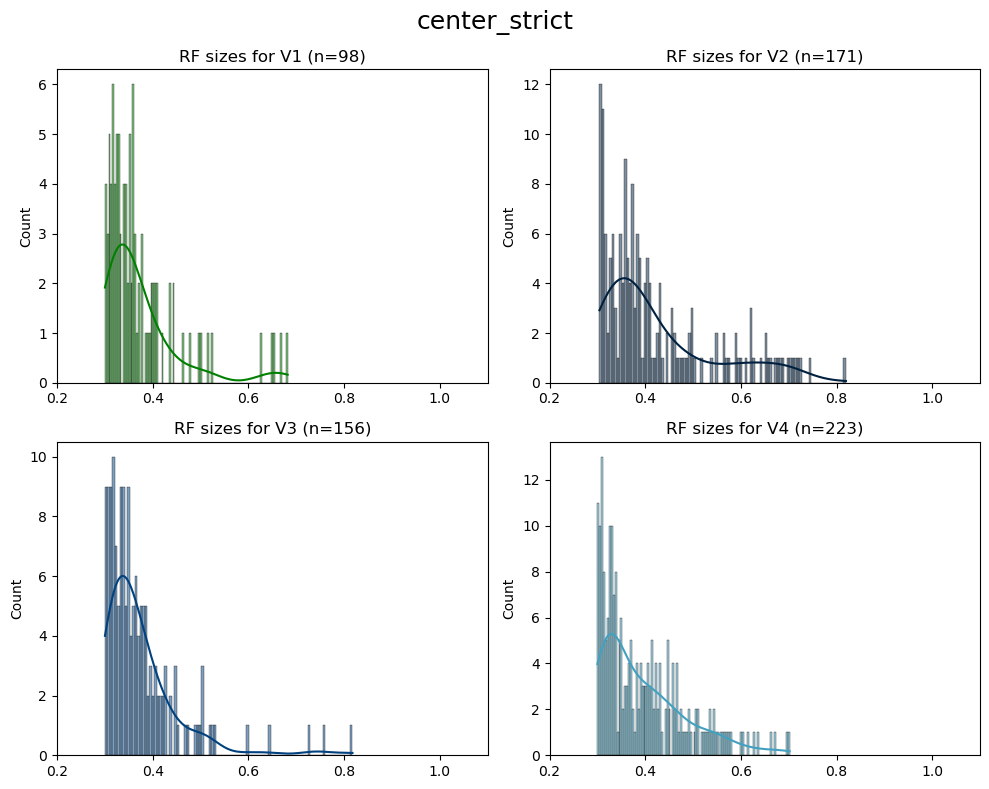

In [7]:
# 1 min
# hrf_dict = get_hrf_dict('subj01', voxels = prf_selection_mask)
hrf_dict_tight, voxmask_tight, joint_voxs, sizes  = get_hrf_dict('subj01', voxels = prf_mask_center_strict, prf_region = 'center_strict', 
                                             min_size = .3, max_size = 1, prf_proc_dict = prf_dict, plot_sizes = 'y')



beta_dict0_5_center_loose.pkl
	Amount of voxels: 156


	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 4500
beta_dict6_15_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 12000
beta_dict16_25_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 19500
beta_dict26_35_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 27000
beta_dict36_39_center_loose.pkl
	Amount of voxels: 156
	Amount of voxels: 161
	Amount of voxels: 160
	Amount of voxels: 111
	Processed images: 30000


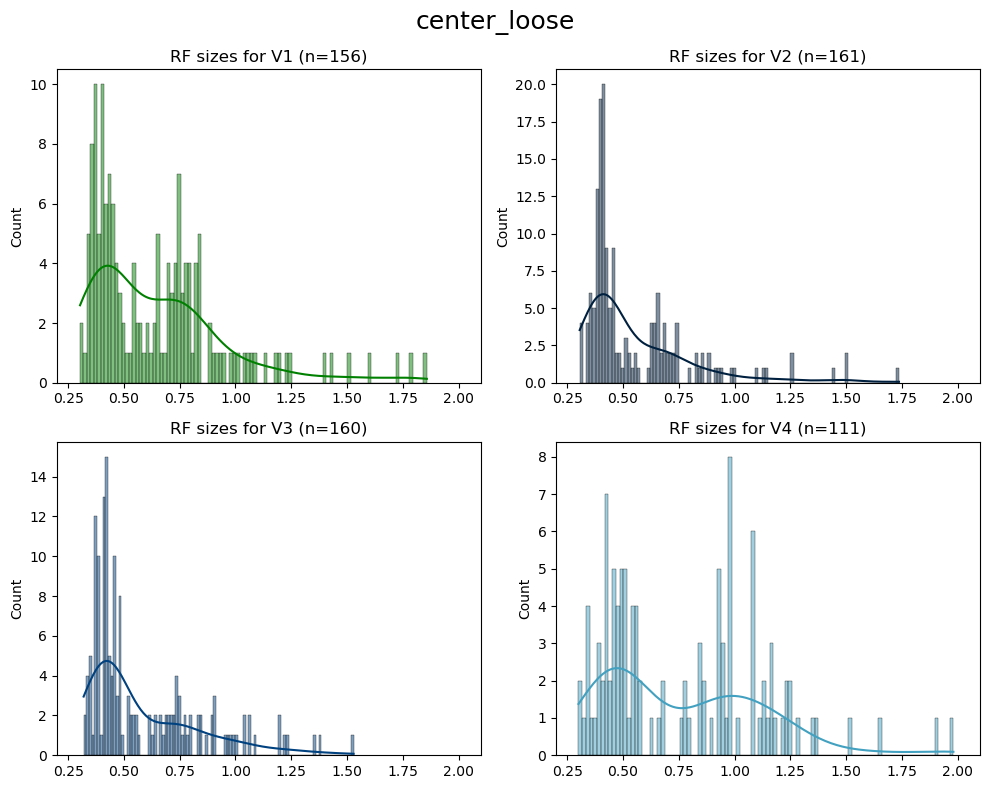

In [8]:
# Create the hrf_dict for the periphery with sizes .2 to 1

hrf_dict_central_loose, voxmask_central_loose, joint_voxs, sizes = get_hrf_dict('subj01', prf_mask_central_loose, prf_region = 'center_loose', 
                                                                    min_size = .3, max_size = 2, prf_proc_dict = prf_dict, 
                                                                    vox_n_cutoff = None, plot_sizes = 'y')

beta_dict0_5_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 4500
beta_dict6_15_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 12000
beta_dict16_25_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 19500
beta_dict26_35_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 27000
beta_dict36_39_periphery.pkl
	Amount of voxels: 139
	Amount of voxels: 143
	Amount of voxels: 147
	Amount of voxels: 147
	Processed images: 30000


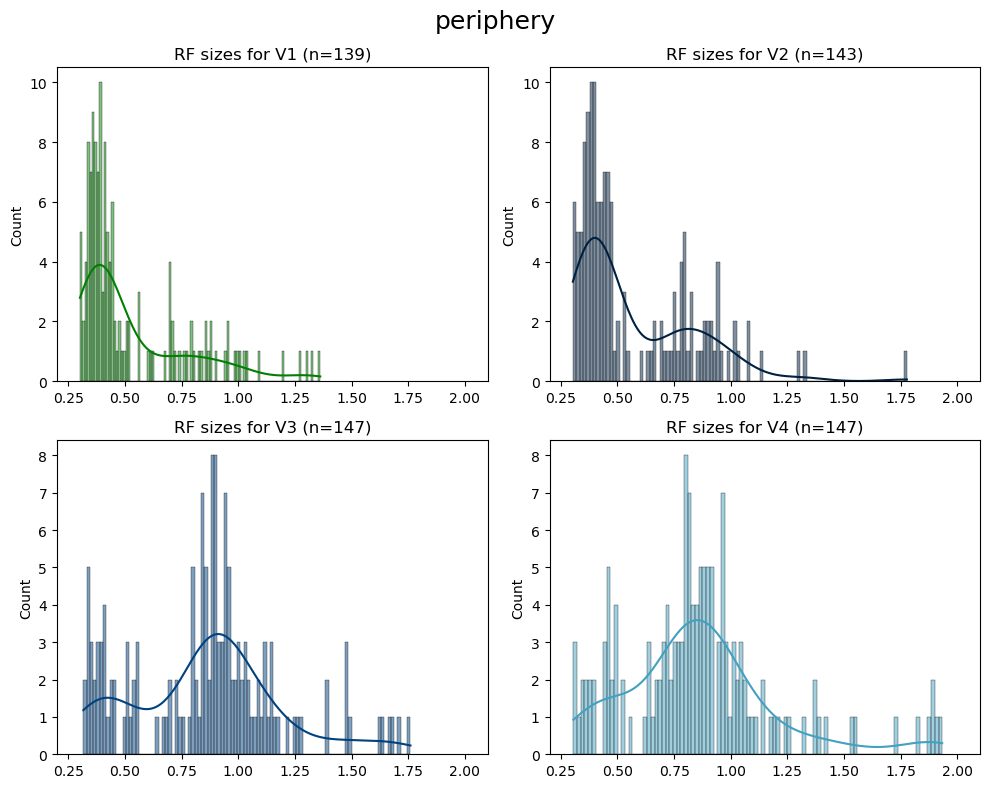

In [9]:
# Create the hrf_dict for the periphery with sizes .2 to 1
# The plot shows the ROI-specific distribution of RF sizes
hrf_dict_peri, voxmask_tight_peri, joint_voxs, sizes = get_hrf_dict('subj01', prf_mask_periphery_strict, prf_region = 'periphery', 
                                                                    min_size = .3, max_size = 2, prf_proc_dict = prf_dict, 
                                                                    vox_n_cutoff = 160, plot_sizes = 'y')


In [10]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery = True,)

regdict_prfc_tight_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)

regdict_prfc_loose_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_mcmc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_mc',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_mcmc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_mc', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)



In [11]:
regstash_mcmc = {}

regstash_mcmc['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_mcmc,
        'irrel': regdict_prfc_tight_rmsirrel_mcmc
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_mcmc,
        'irrel': regdict_prfc_loose_rmsirrel_mcmc
    }

}

regstash_mcmc['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_mcmc,
        'irrel': regdict_prfp_tight_rmsirrel_mcmc
    }
}

In [14]:
# The old z-score (over total)
# regdict_prfc_tight_rmsrel_z['V1_mask']['y_matrix']

# array([[-0.43006, -0.29205, -0.08803, ..., -0.48806, -0.8481 , -1.86018],
#        [-1.00411, -0.72609, -0.24604, ..., -0.21204, -0.27405, -1.19013],
#        [-1.15012, -0.31005, -0.23404, ..., -0.10803, -2.73426,  0.69804],
#        ...,
#        [-0.9241 ,  0.286  ,  0.15999, ...,  0.212  , -3.1403 ,  1.4061 ],
#        [-0.02802,  0.13399,  0.51402, ...,  0.238  , -3.50033,  0.80805],
#        [-0.73609,  0.14799,  0.06198, ..., -0.17804, -5.4525 ,  1.61012]])


In [15]:
# The new z-score (per session)
# regdict_prfc_tight_rmsrel_z['V1_mask']['y_matrix']

# array([[-0.65082, -0.50525, -0.29005, ..., -0.71201, -1.09177, -2.15934],
#        [-1.25634, -0.96308, -0.45672, ..., -0.42085, -0.48626, -1.45255],
#        [-1.41036, -0.52424, -0.44406, ..., -0.31114, -3.08133,  0.53911],
#        ...,
#        [-0.9747 ,  0.42263,  0.27712, ...,  0.33717, -3.53376,  1.71602],
#        [ 0.06002,  0.2471 ,  0.68592, ...,  0.3672 , -3.94949,  1.02544],
#        [-0.75759,  0.26326,  0.16395, ..., -0.11321, -6.20368,  1.9516 ]])


In [16]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery = True,)

regdict_prfc_tight_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)

regdict_prfc_loose_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_mc, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False, meancentery=True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_mc, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False, meancentery=True)



In [17]:
regstash_mc = {}

regstash_mc['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_mc,
        'irrel': regdict_prfc_tight_rmsirrel_mc
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_mc,
        'irrel': regdict_prfc_loose_rmsirrel_mc
    }

}

regstash_mc['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_mc,
        'irrel': regdict_prfp_tight_rmsirrel_mc
    }
}

In [18]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)

regdict_prfc_loose_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel_z, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = True)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel_z, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = True)



In [19]:
regstash_z = {}

regstash_z['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel_z,
        'irrel': regdict_prfc_tight_rmsirrel_z
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel_z,
        'irrel': regdict_prfc_loose_rmsirrel_z
    }

}

regstash_z['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel_z,
        'irrel': regdict_prfp_tight_rmsirrel_z
    }
}

In [20]:
# Regression for the relevant and irrelevant RMS values for the central strict RFs

regdict_prfc_tight_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)

regdict_prfc_tight_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight, hrf_dict_tight, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)

# Regression for the relevant and irrelevant RMS values for the central loose RFs

regdict_prfc_loose_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)

regdict_prfc_loose_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_central_loose, hrf_dict_central_loose, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)

# Regression for the relevant and irrelevant RMS values for the strict peripheral RFs

regdict_prfp_tight_rmsrel, X_subj1_rel = regression_dict_multivariate('subj01', 'rms_z',voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms'], n_imgs=30000, z_scorey = False)


# Does this make sense? no not really. These is a comparison between peripheral RF HRF signal and the irrelevant RMS values (which a proportion of the
# RFs actually overlap with). I could check out whether peripheral RFs are location specific in their responses, but that is like a sanity check
# of a sanity check of a sanity check, not really crucial.
regdict_prfp_tight_rmsirrel, X_subj1_irrel = regression_dict_multivariate('subj01', 'rms_z', voxmask_tight_peri, hrf_dict_peri, 
                                                                                            visfeats_rms['subj01']['rms_irrelevant'], n_imgs=30000, z_scorey = False)



Stash the different regression dictionaries in another dictionary to make access more intuitive.

In [21]:
regstash = {}

regstash['centralprfs'] = {
    'tight': {
        'rel': regdict_prfc_tight_rmsrel,
        'irrel': regdict_prfc_tight_rmsirrel
    },
    'loose': {
        'rel': regdict_prfc_loose_rmsrel,
        'irrel': regdict_prfc_loose_rmsirrel
    }

}

regstash['peripheralprfs'] = {
    'tight': {
        'rel': regdict_prfp_tight_rmsrel,
        'irrel': regdict_prfp_tight_rmsirrel
    }
}

### Raw vs. Z-score vs. Mean centering

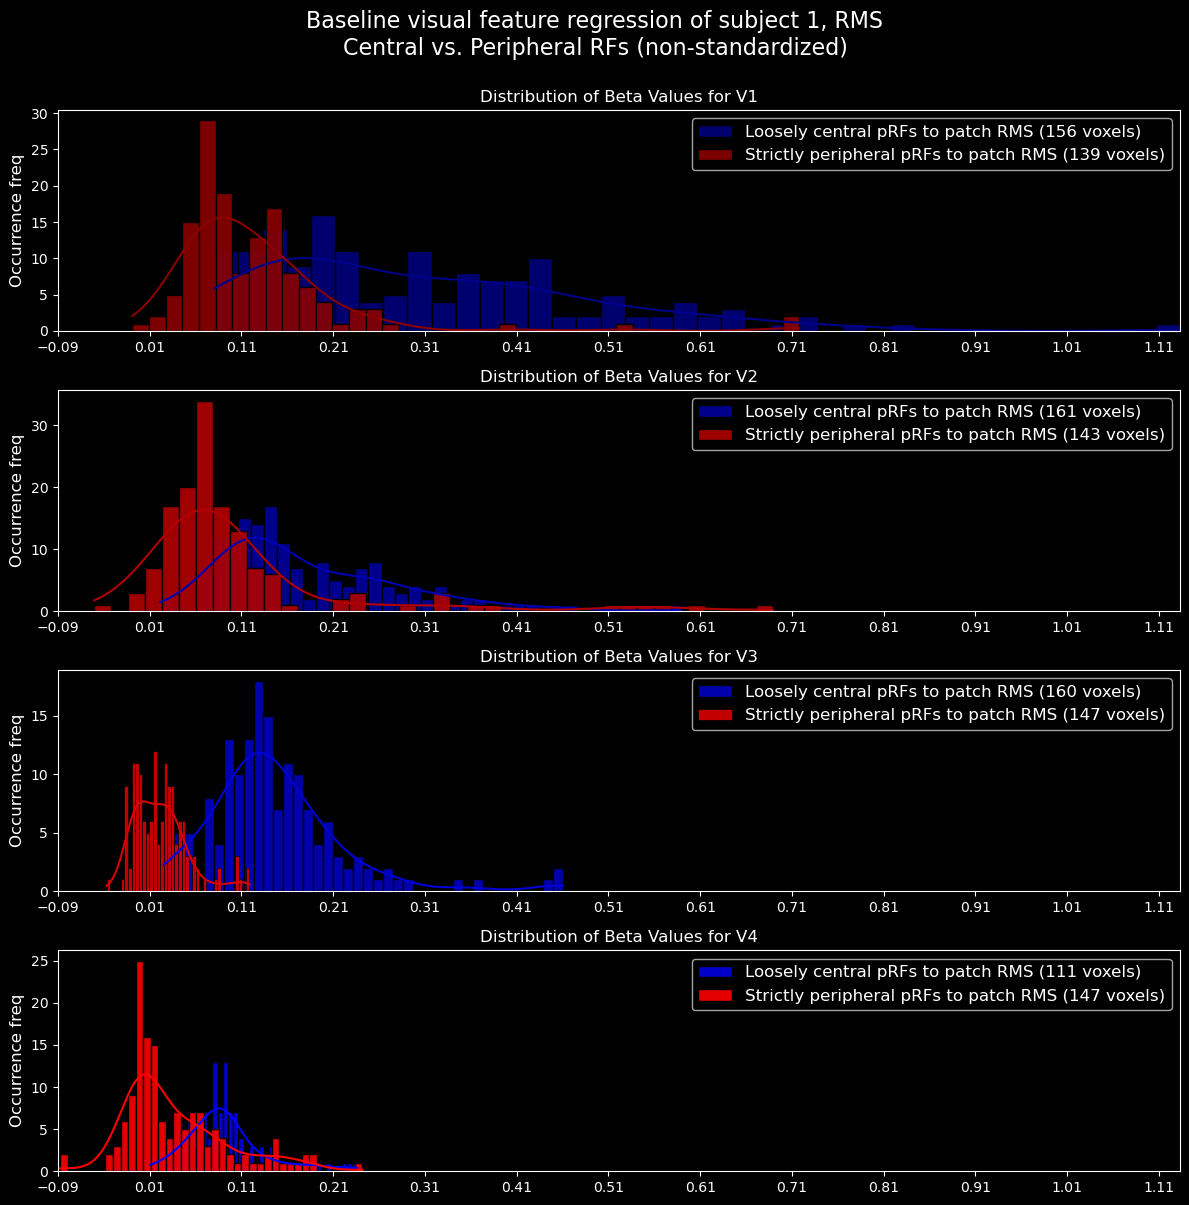

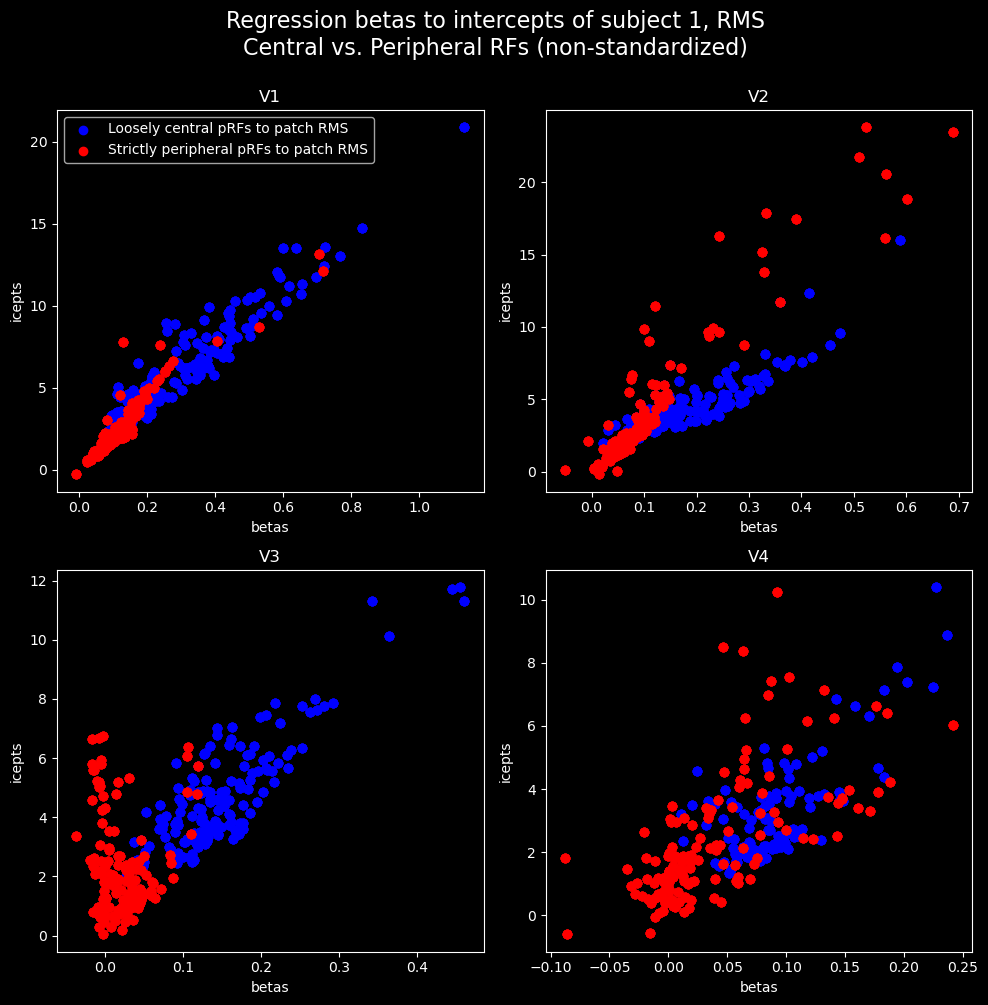

In [53]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs (non-standardized)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

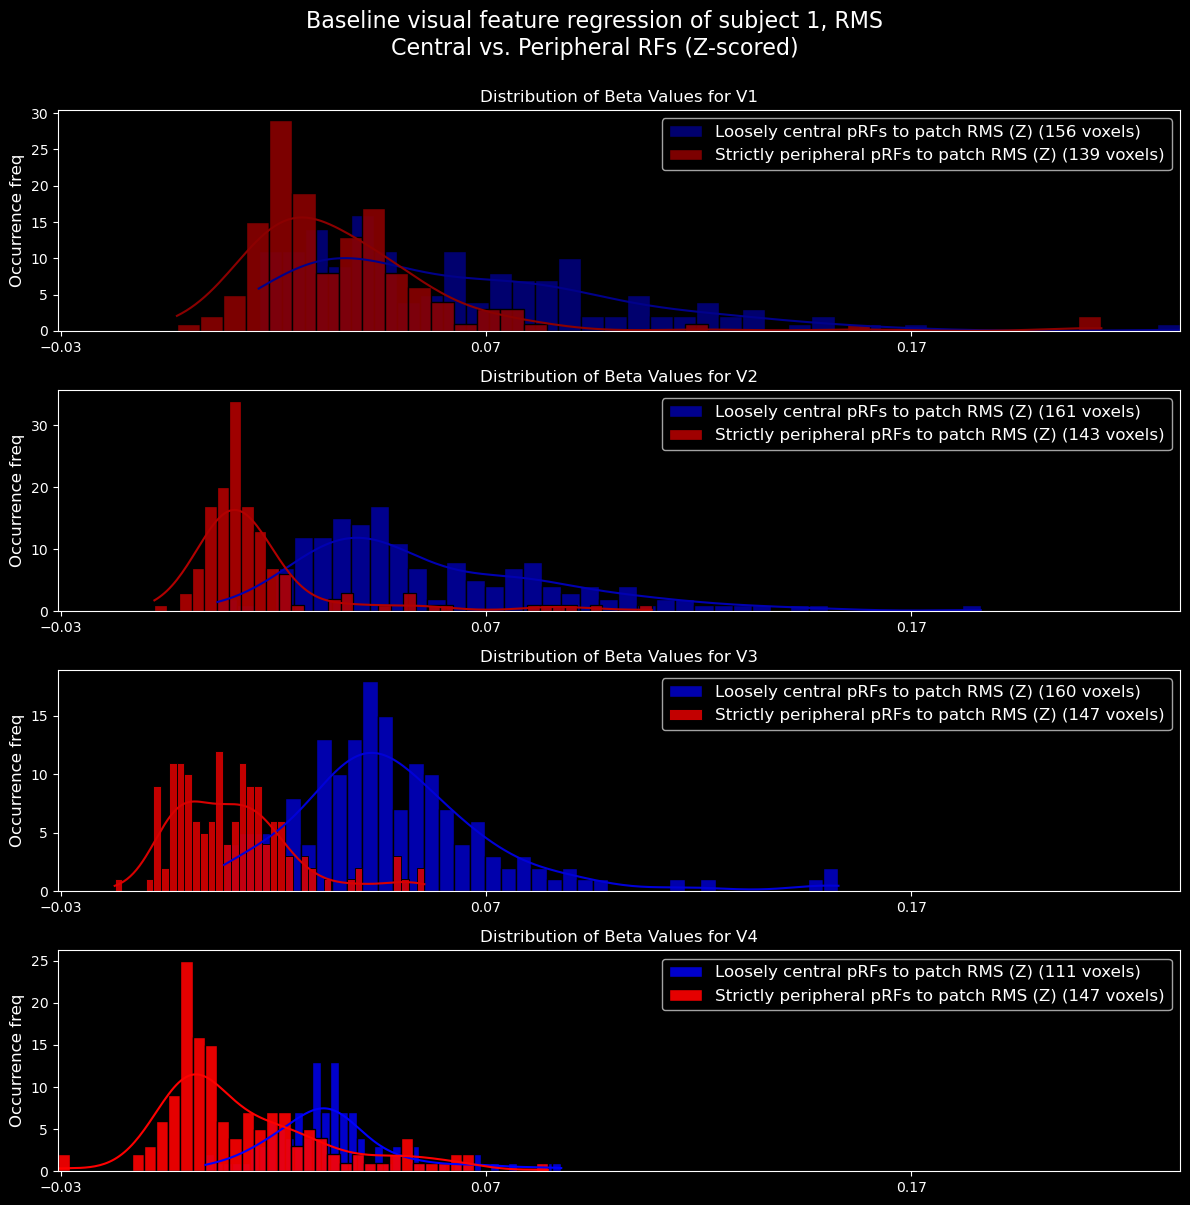

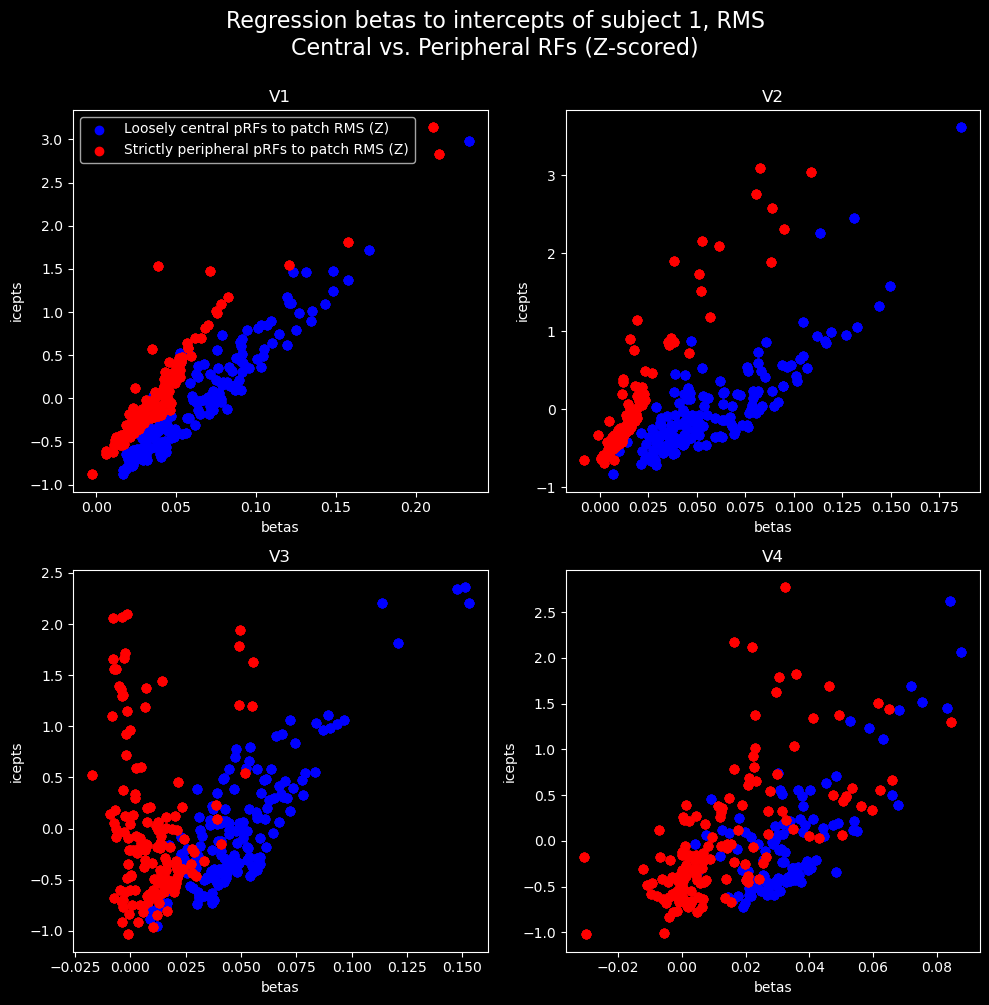

In [54]:

reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (Z)', comptype = 'Central vs. Peripheral RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

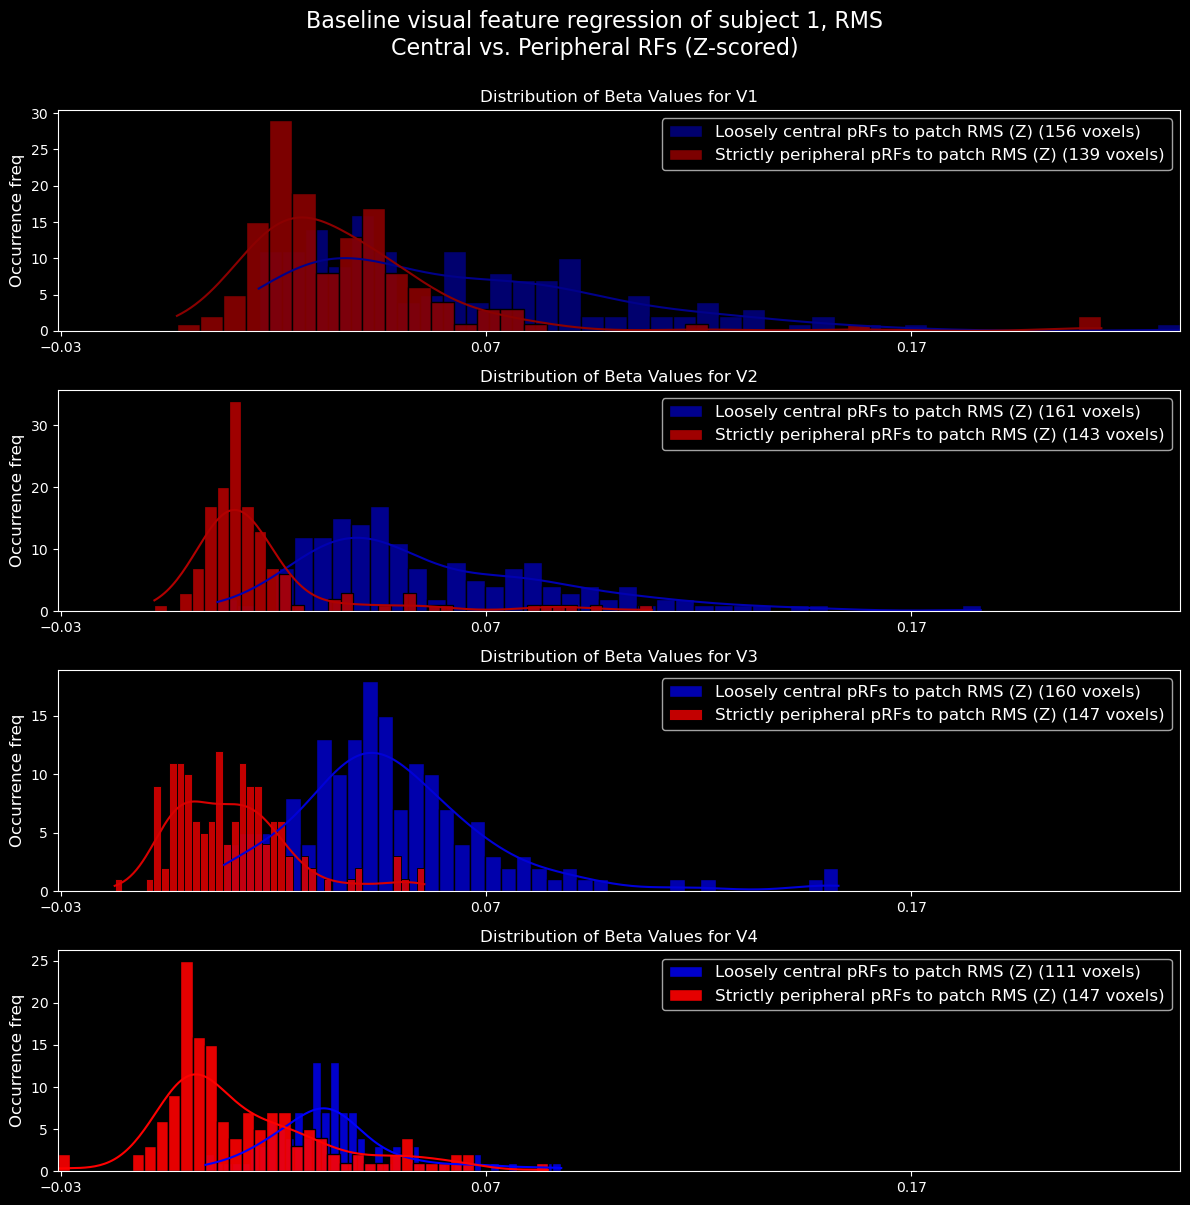

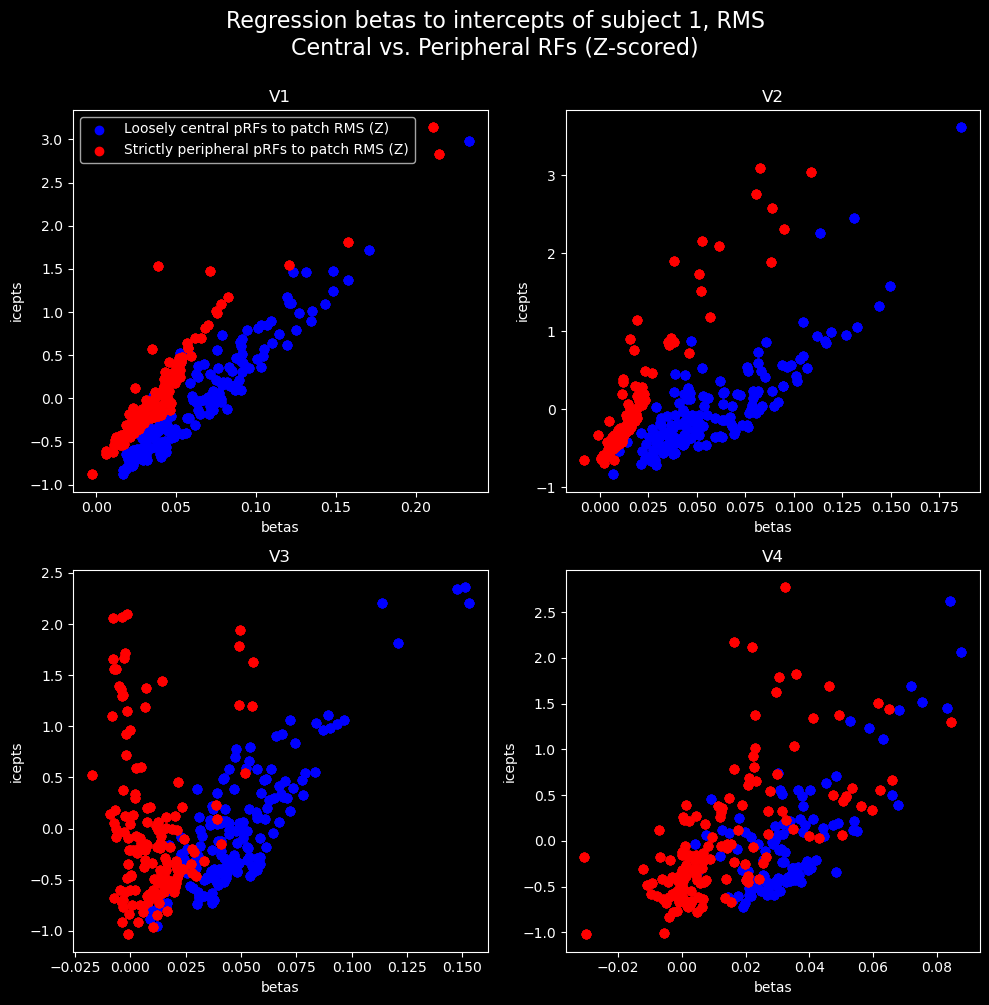

In [22]:
# NEW 
reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (Z)', comptype = 'Central vs. Peripheral RFs (Z-scored)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

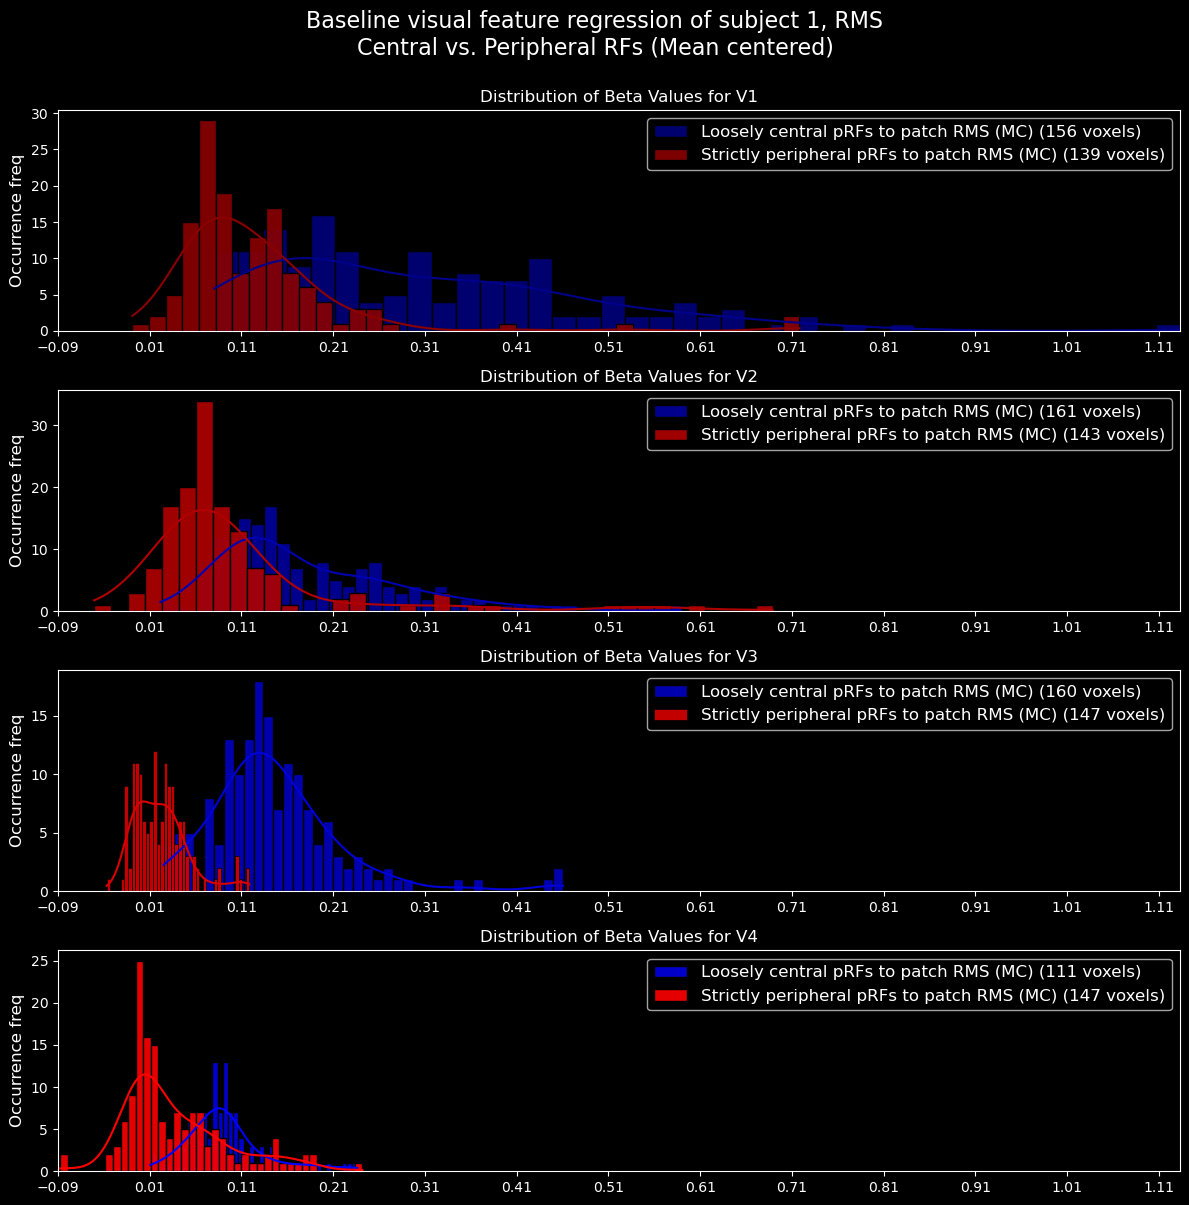

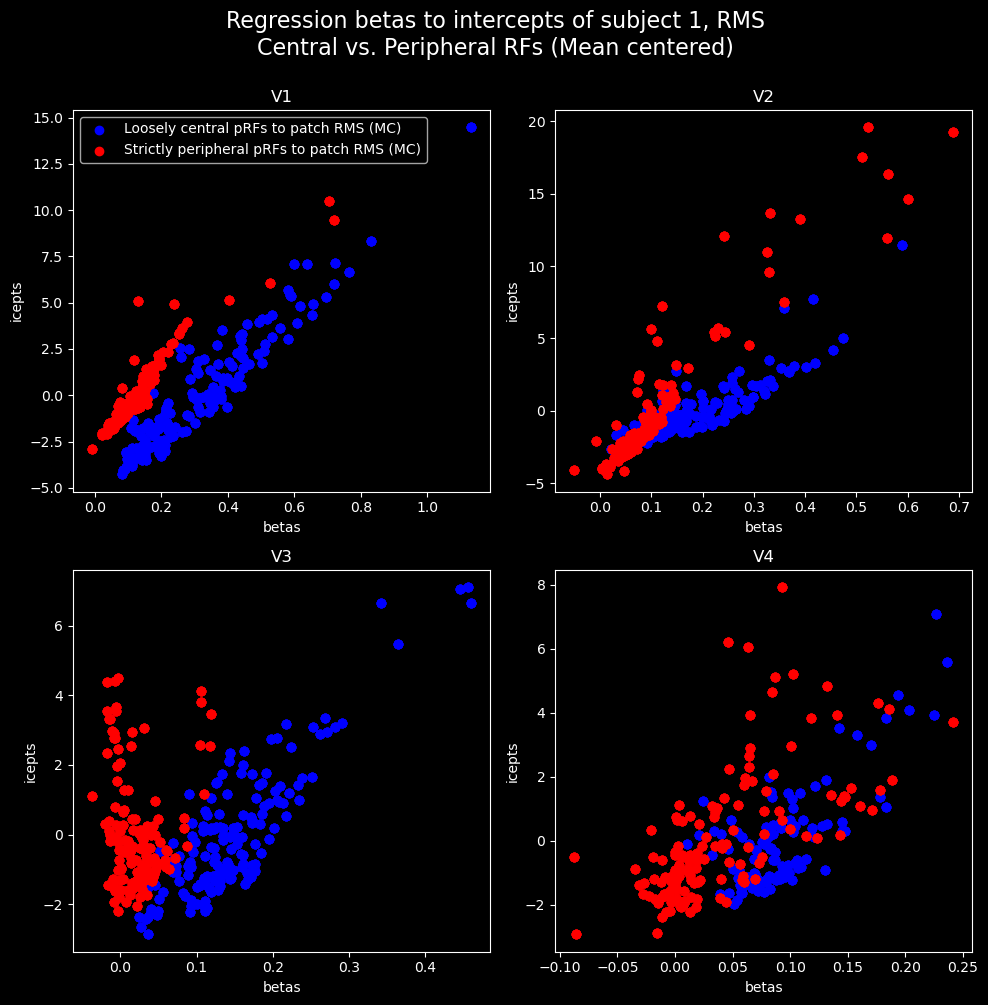

In [55]:

reg_plots(regstash_mc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MC)', comptype = 'Central vs. Peripheral RFs (Mean centered)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)

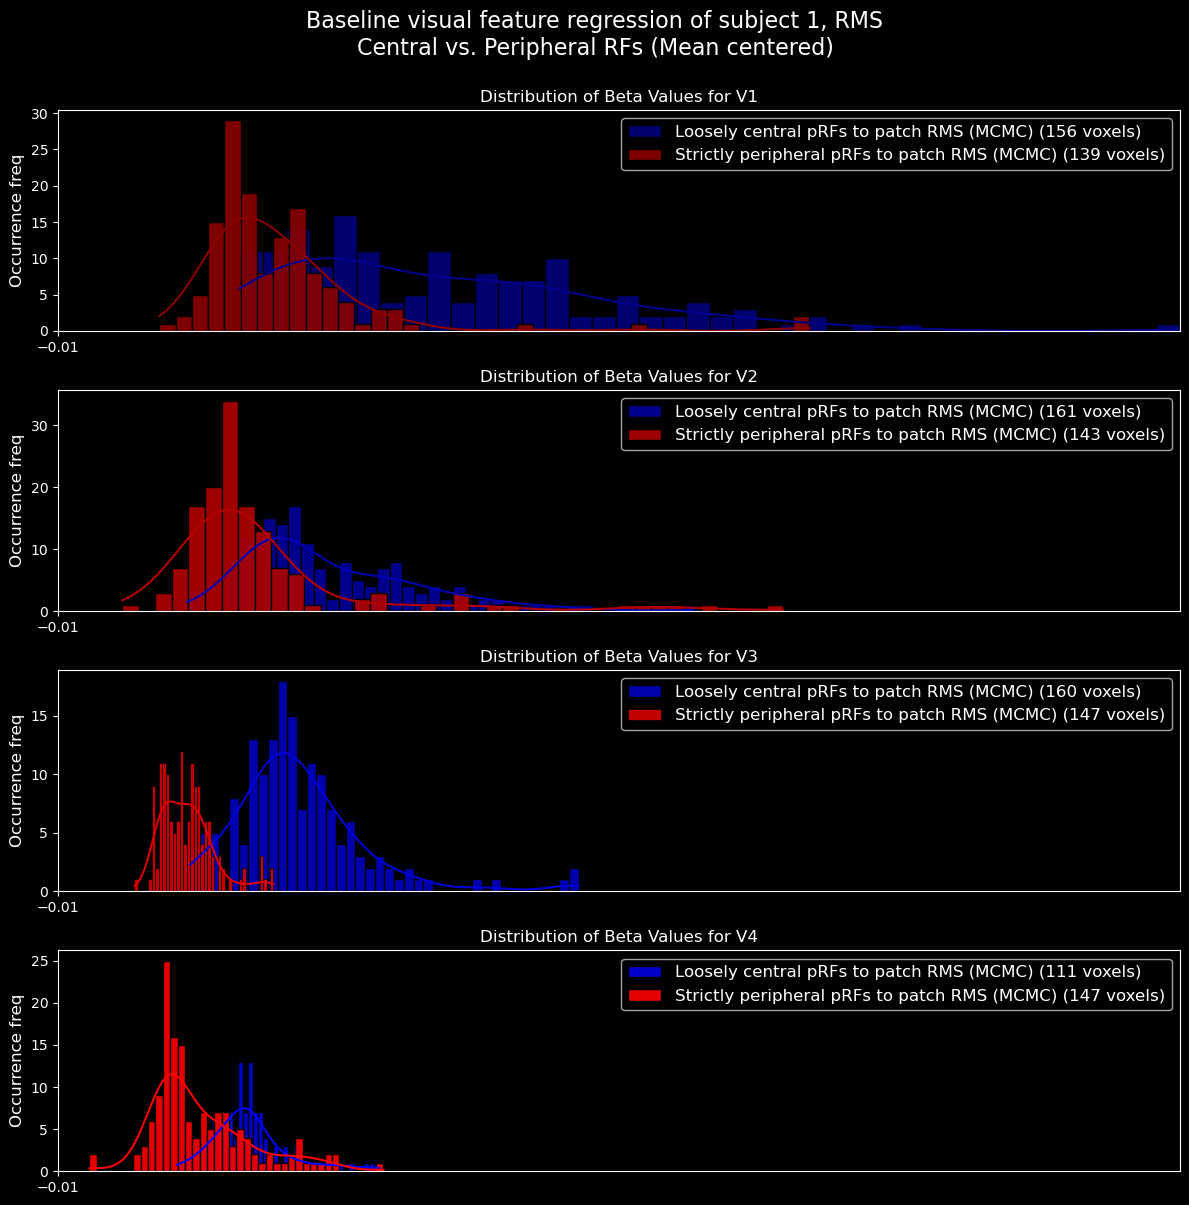

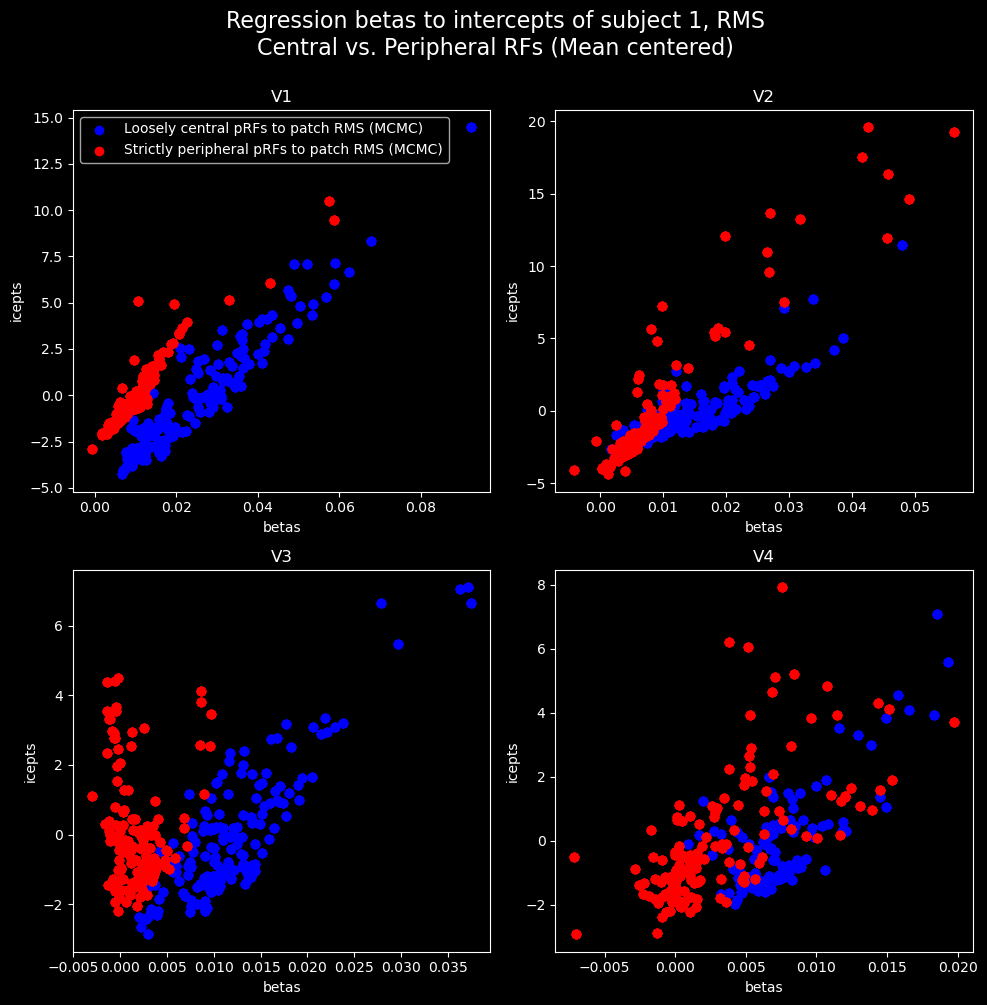

In [56]:

reg_plots(regstash_mcmc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MCMC)', comptype = 'Central vs. Peripheral RFs (Mean centered)',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mcmc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MCMC)', beta_hist = True, beta_icept = True)

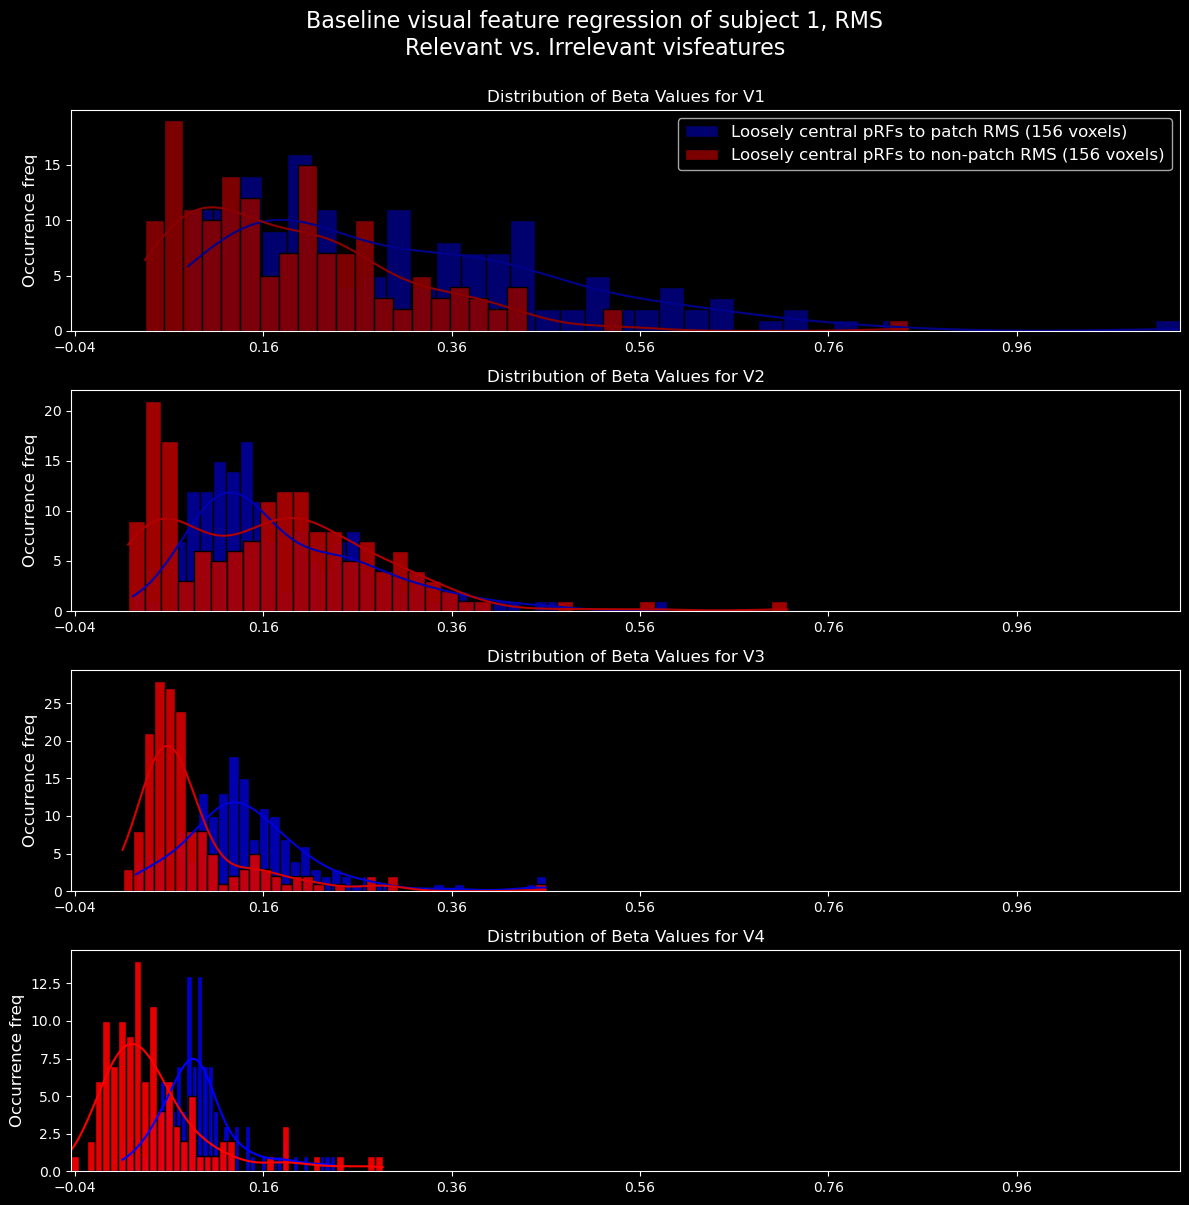

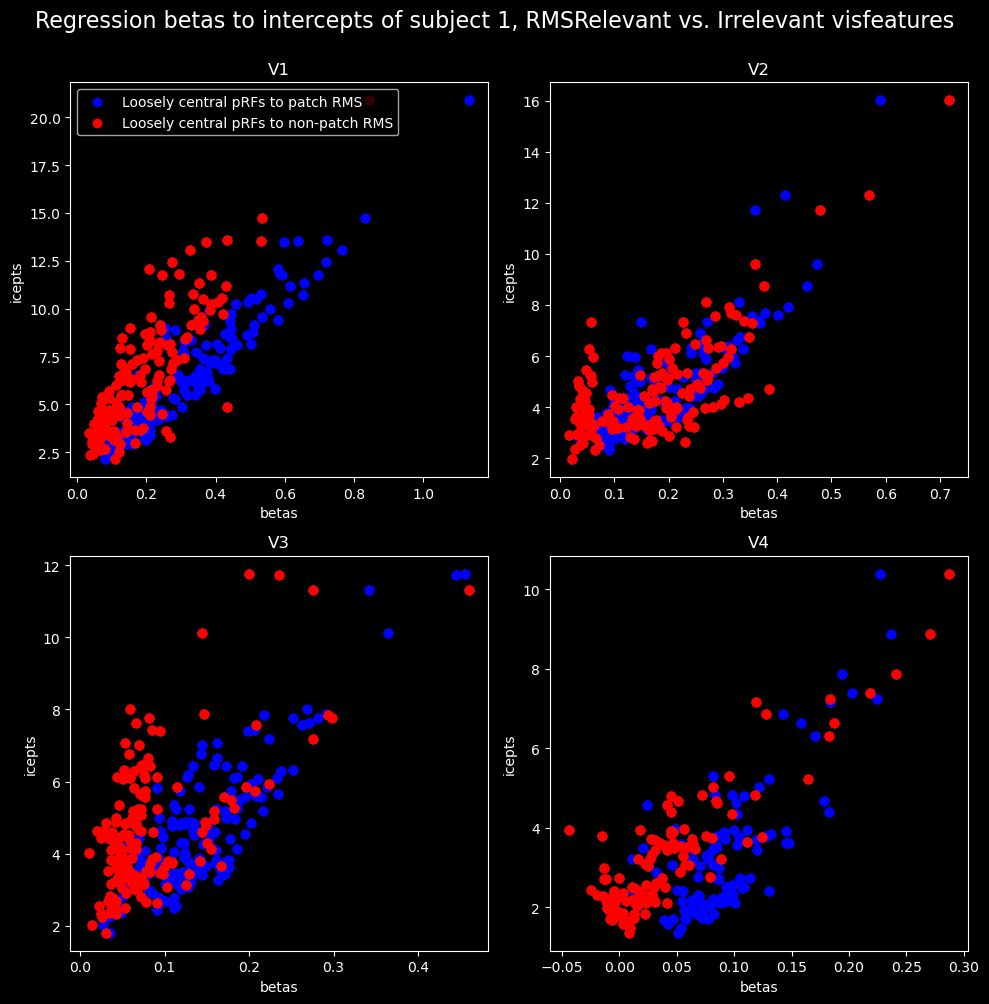

In [23]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['centralprfs']['loose']['irrel'], 
                           dictdescrip2 = 'Loosely central pRFs to non-patch RMS', beta_hist = True, beta_icept = True)

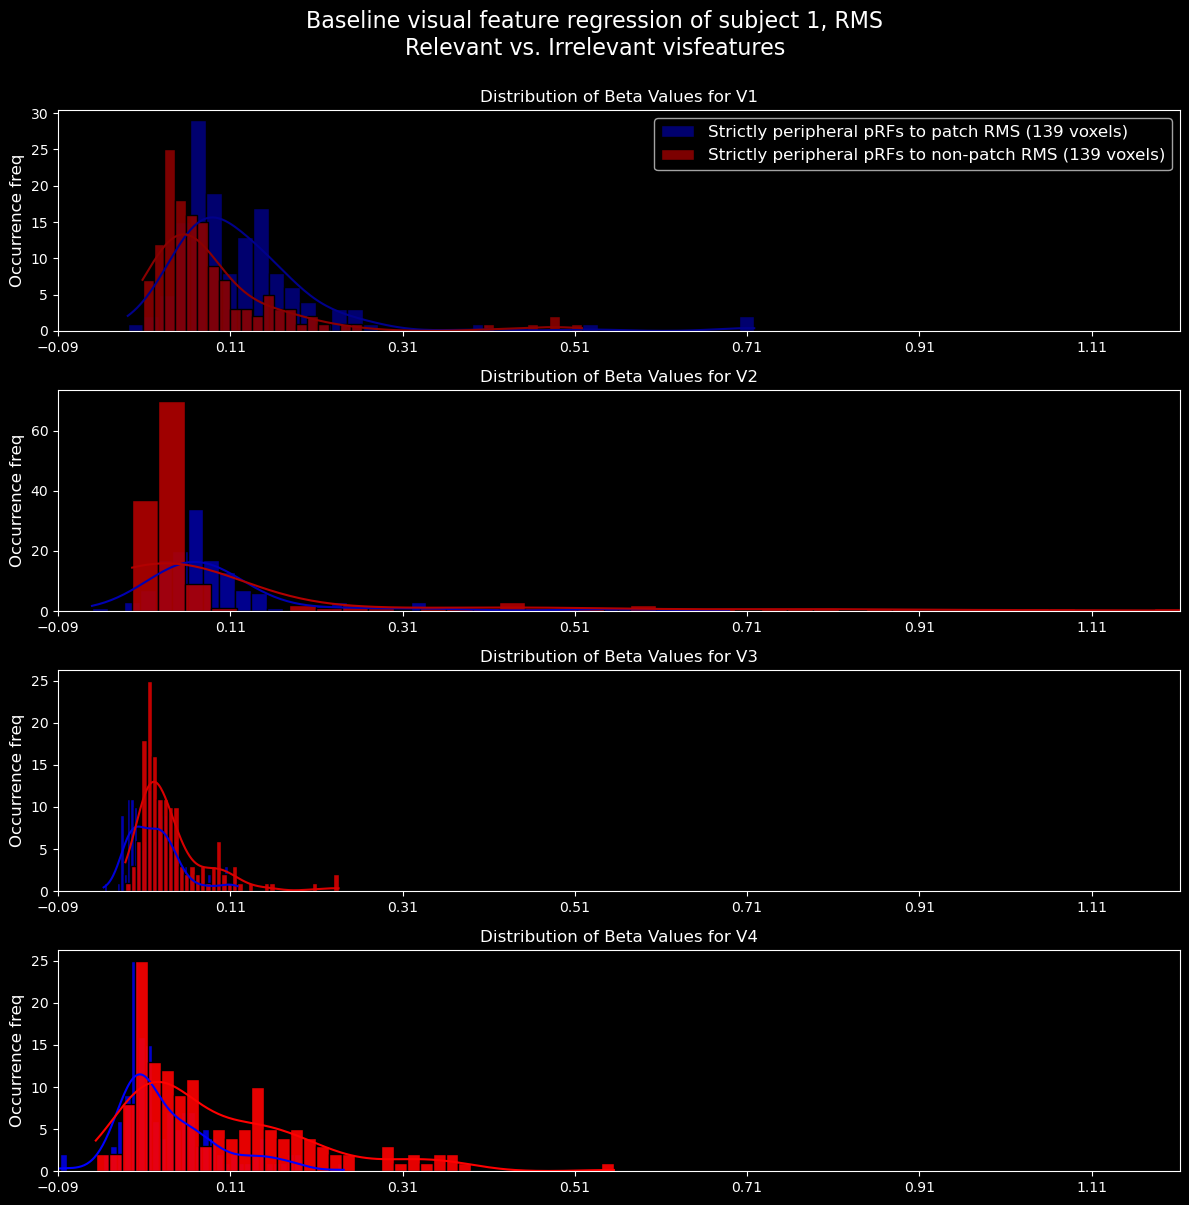

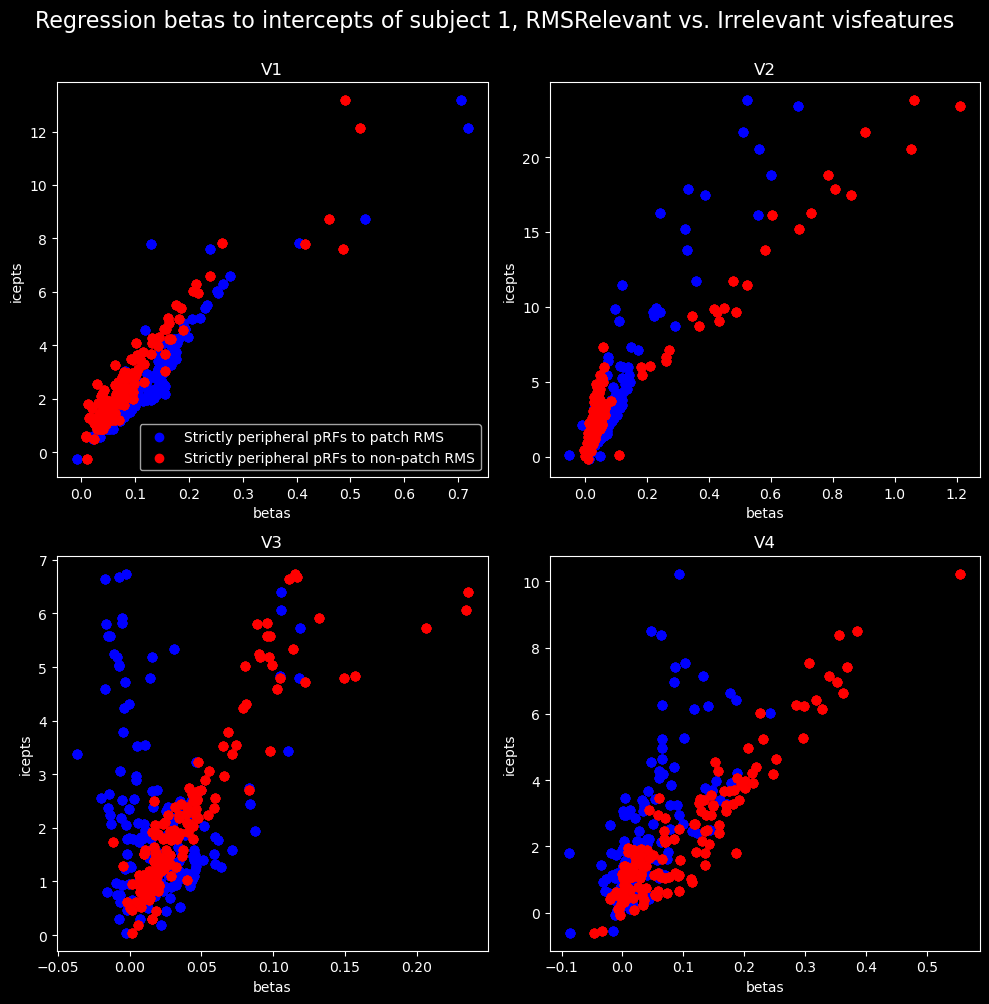

In [22]:

reg_plots(regstash['peripheralprfs']['tight']['rel'], dictdescrip1 = 'Strictly peripheral pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['irrel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to non-patch RMS', beta_hist = True, beta_icept = True)

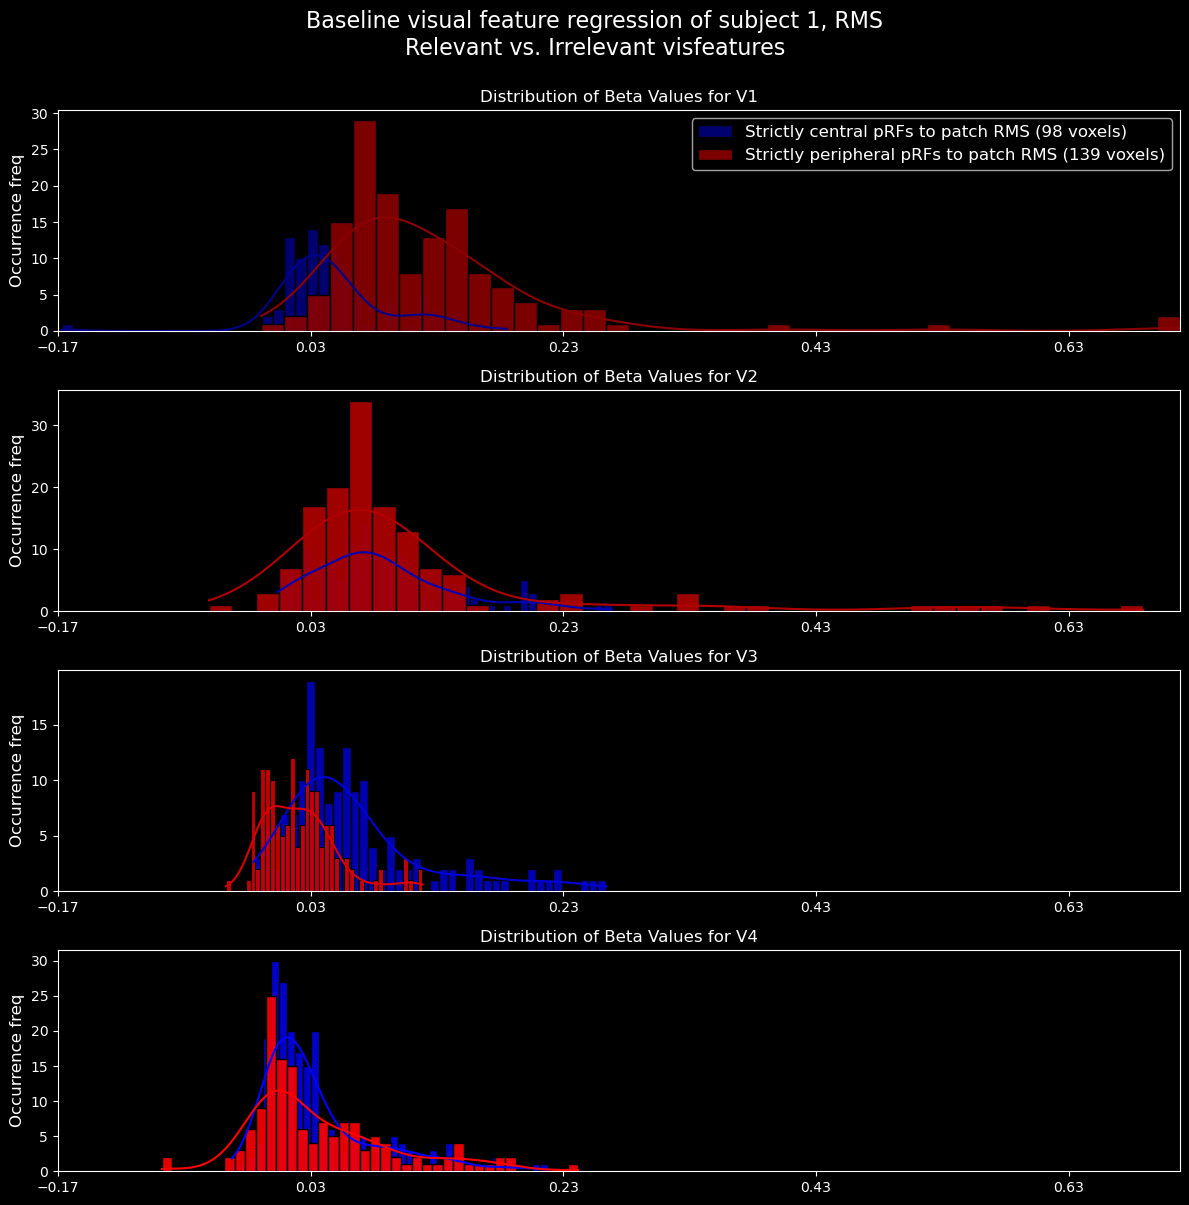

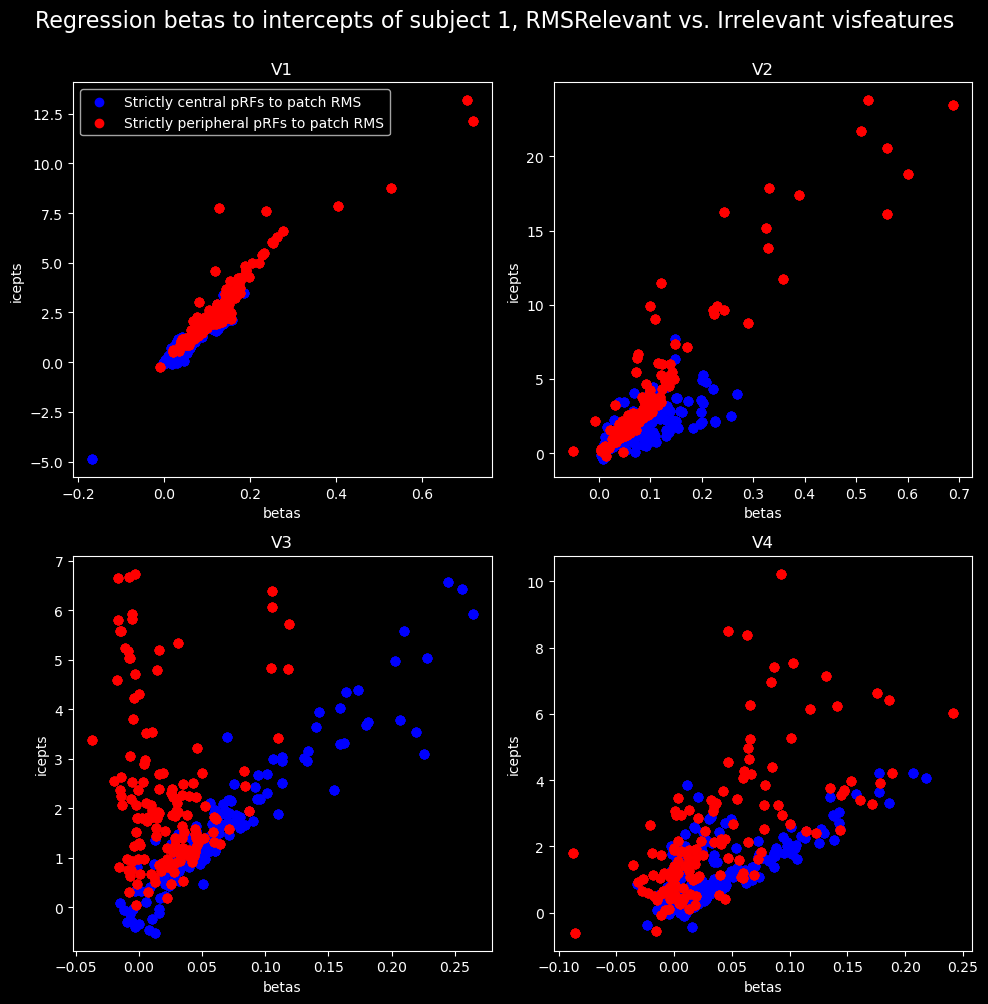

In [27]:

reg_plots(regstash['centralprfs']['tight']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Relevant vs. Irrelevant visfeatures',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

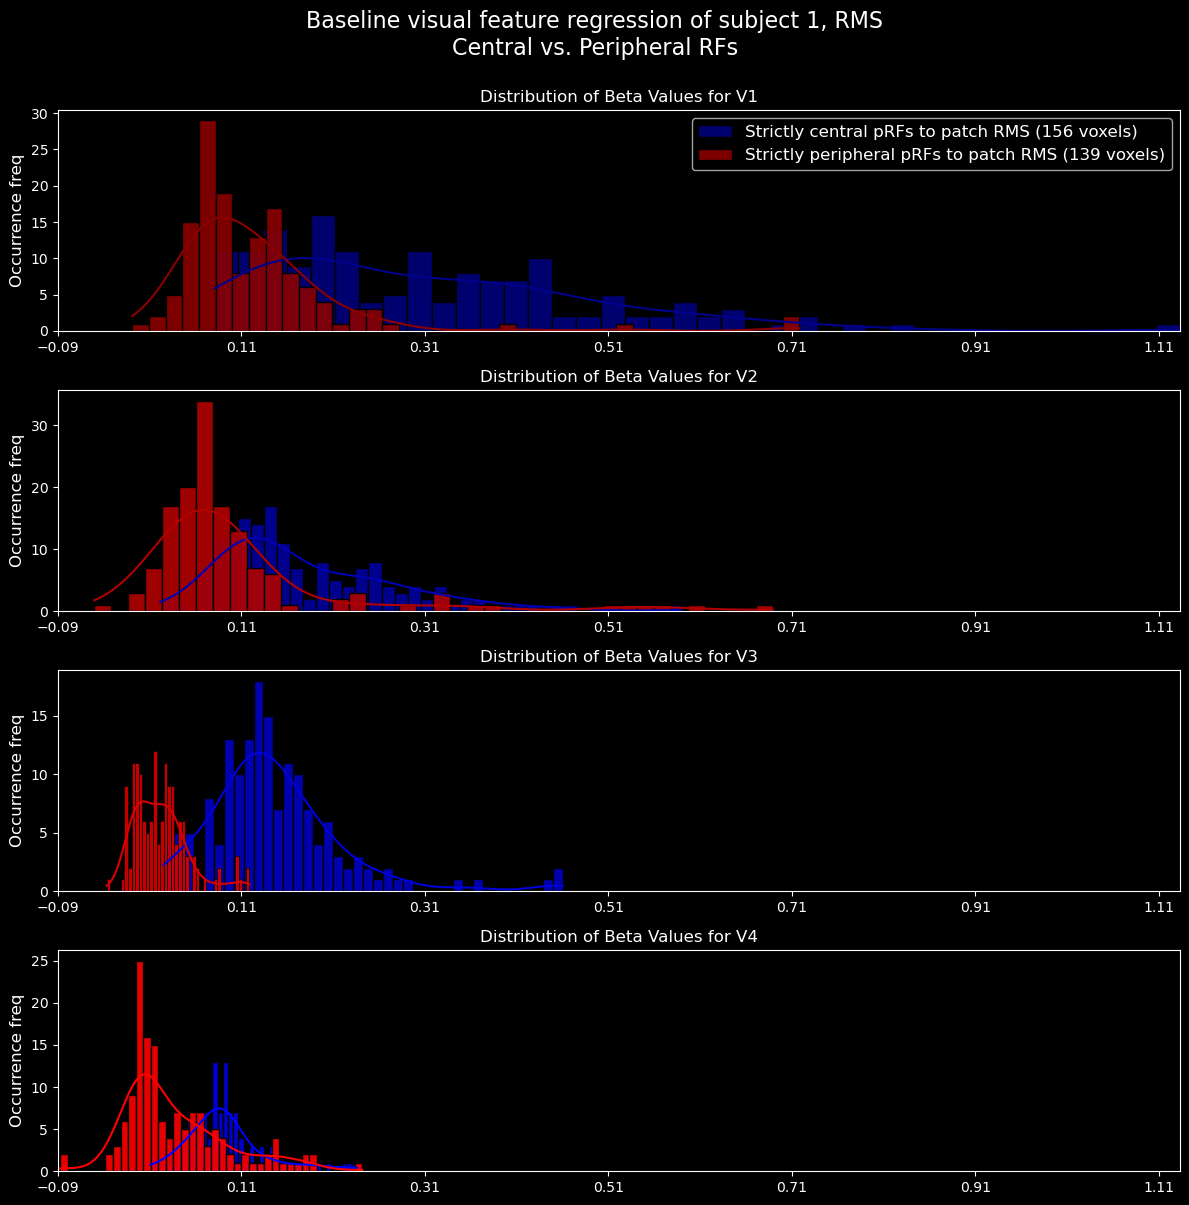

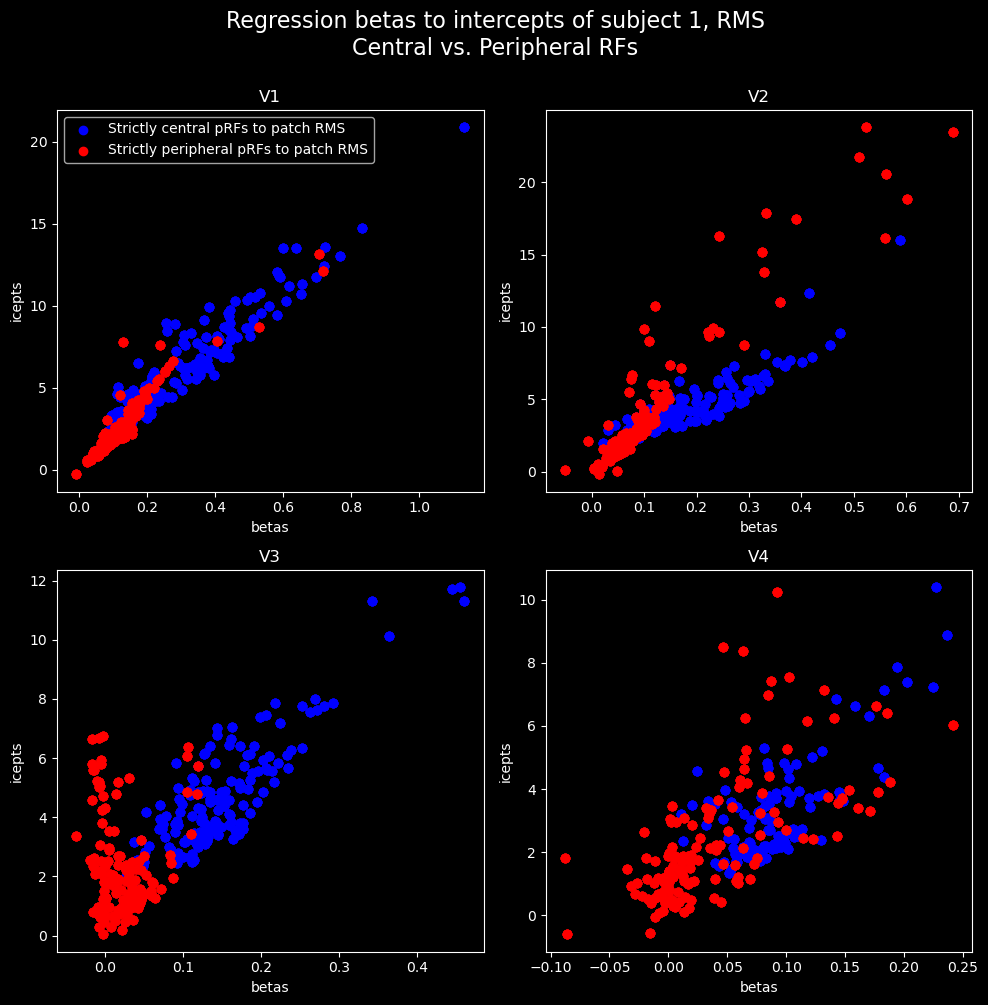

In [26]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

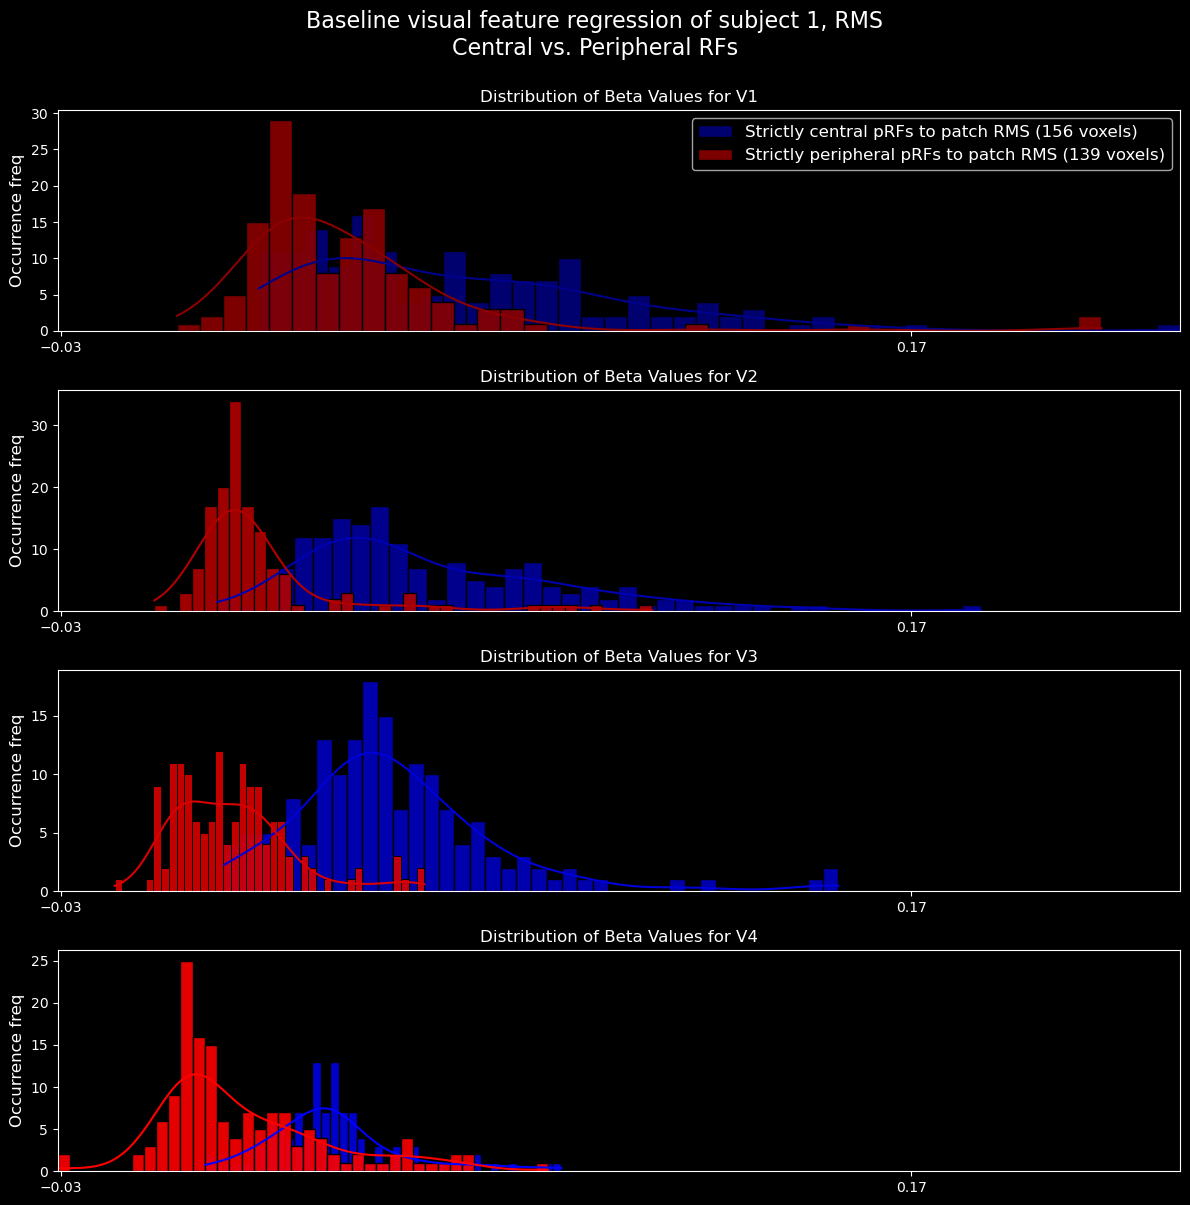

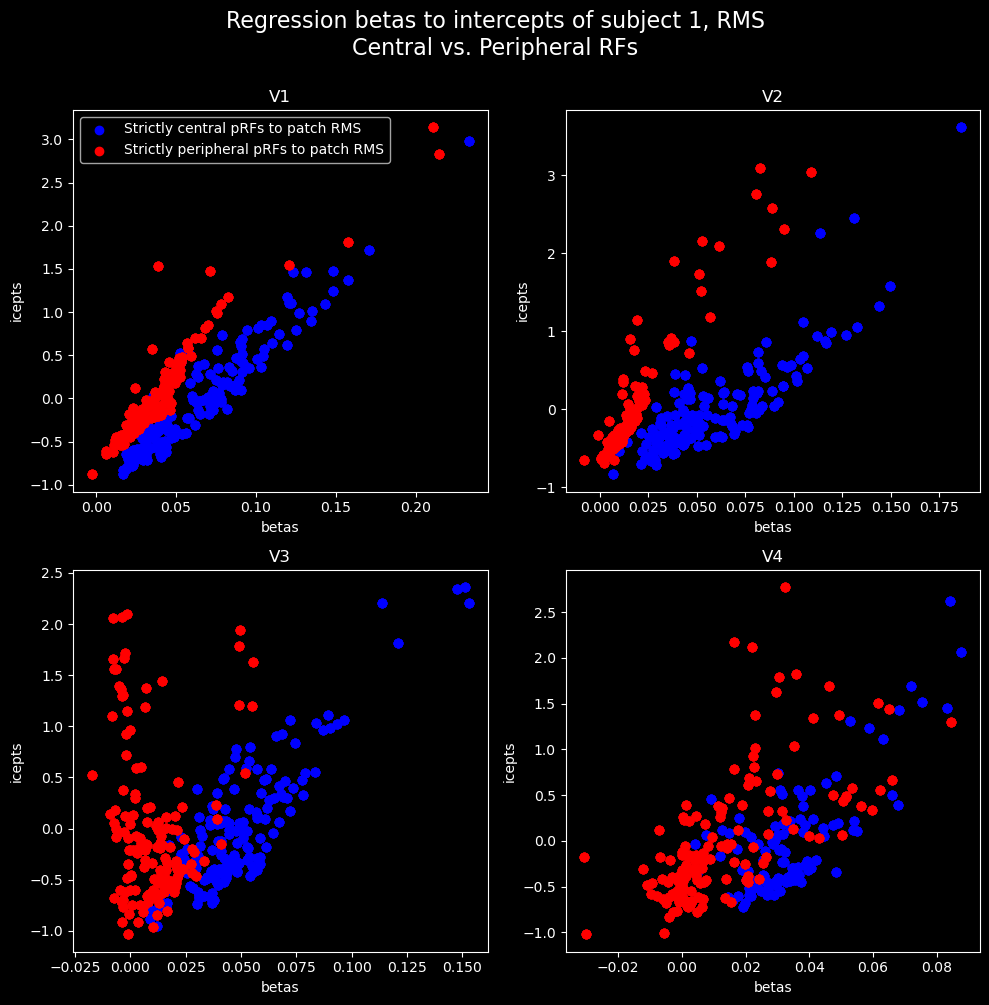

In [27]:

reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS', beta_hist = True, beta_icept = True)

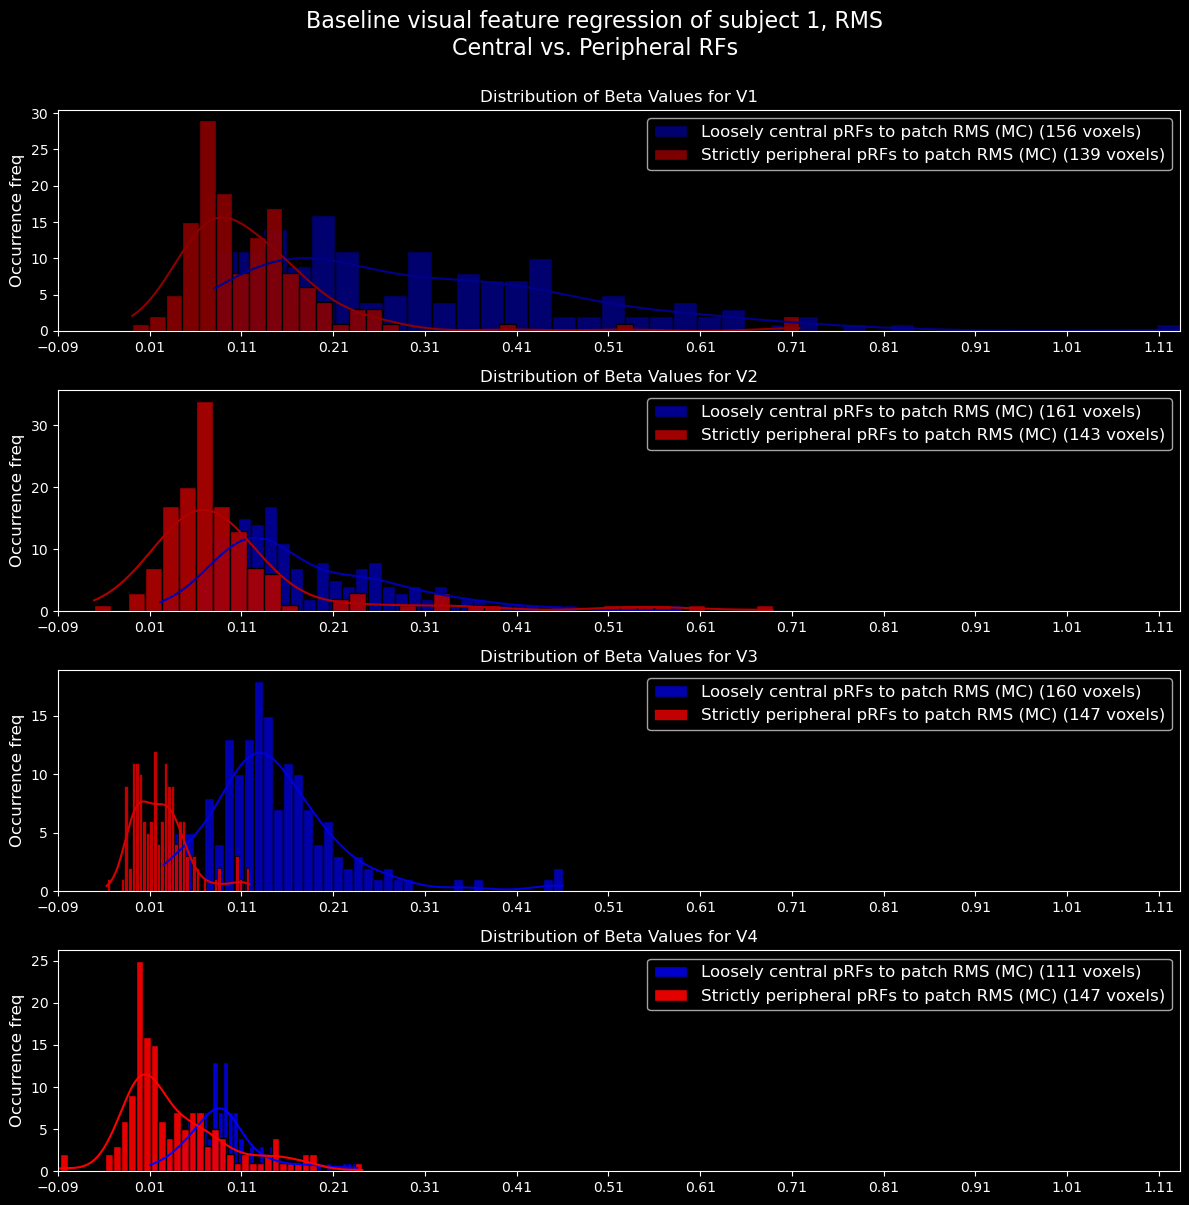

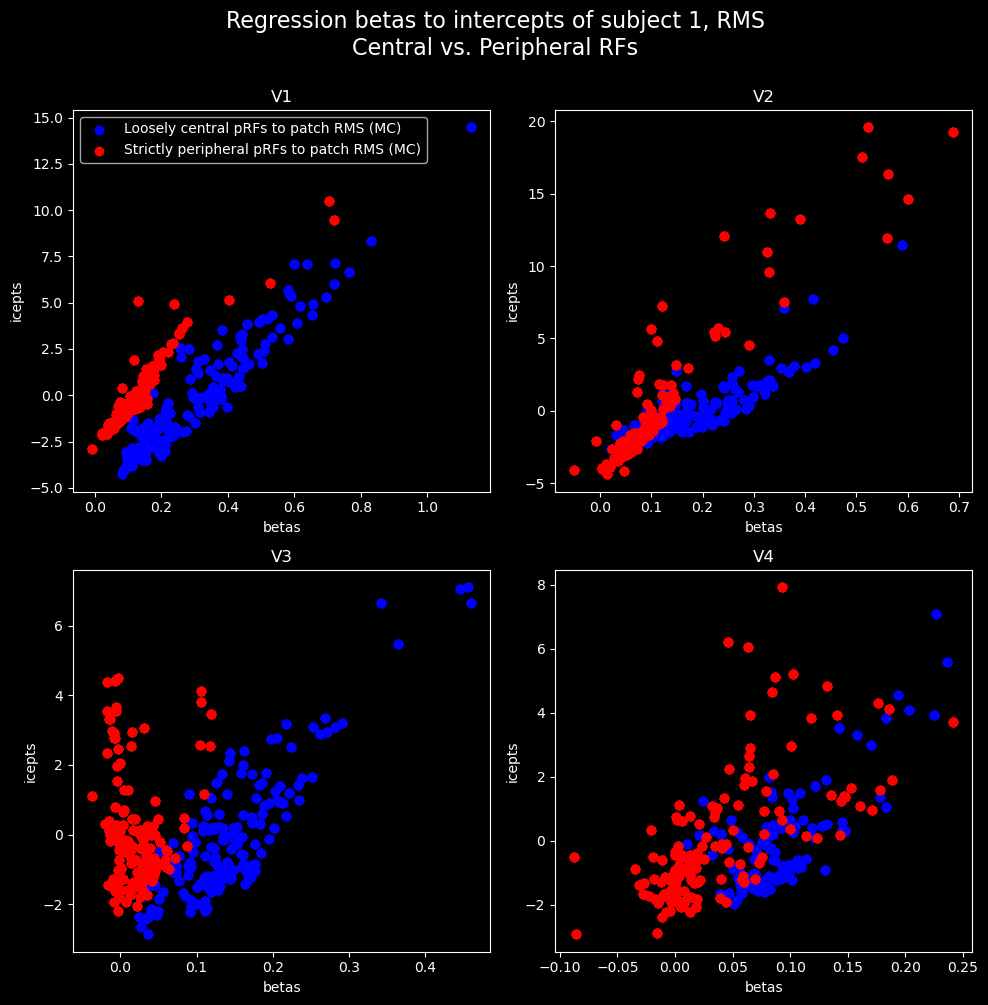

In [17]:

reg_plots(regstash_mc['centralprfs']['loose']['rel'], dictdescrip1 = 'Loosely central pRFs to patch RMS (MC)', comptype = 'Central vs. Peripheral RFs',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['peripheralprfs']['tight']['rel'], 
                           dictdescrip2 = 'Strictly peripheral pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)

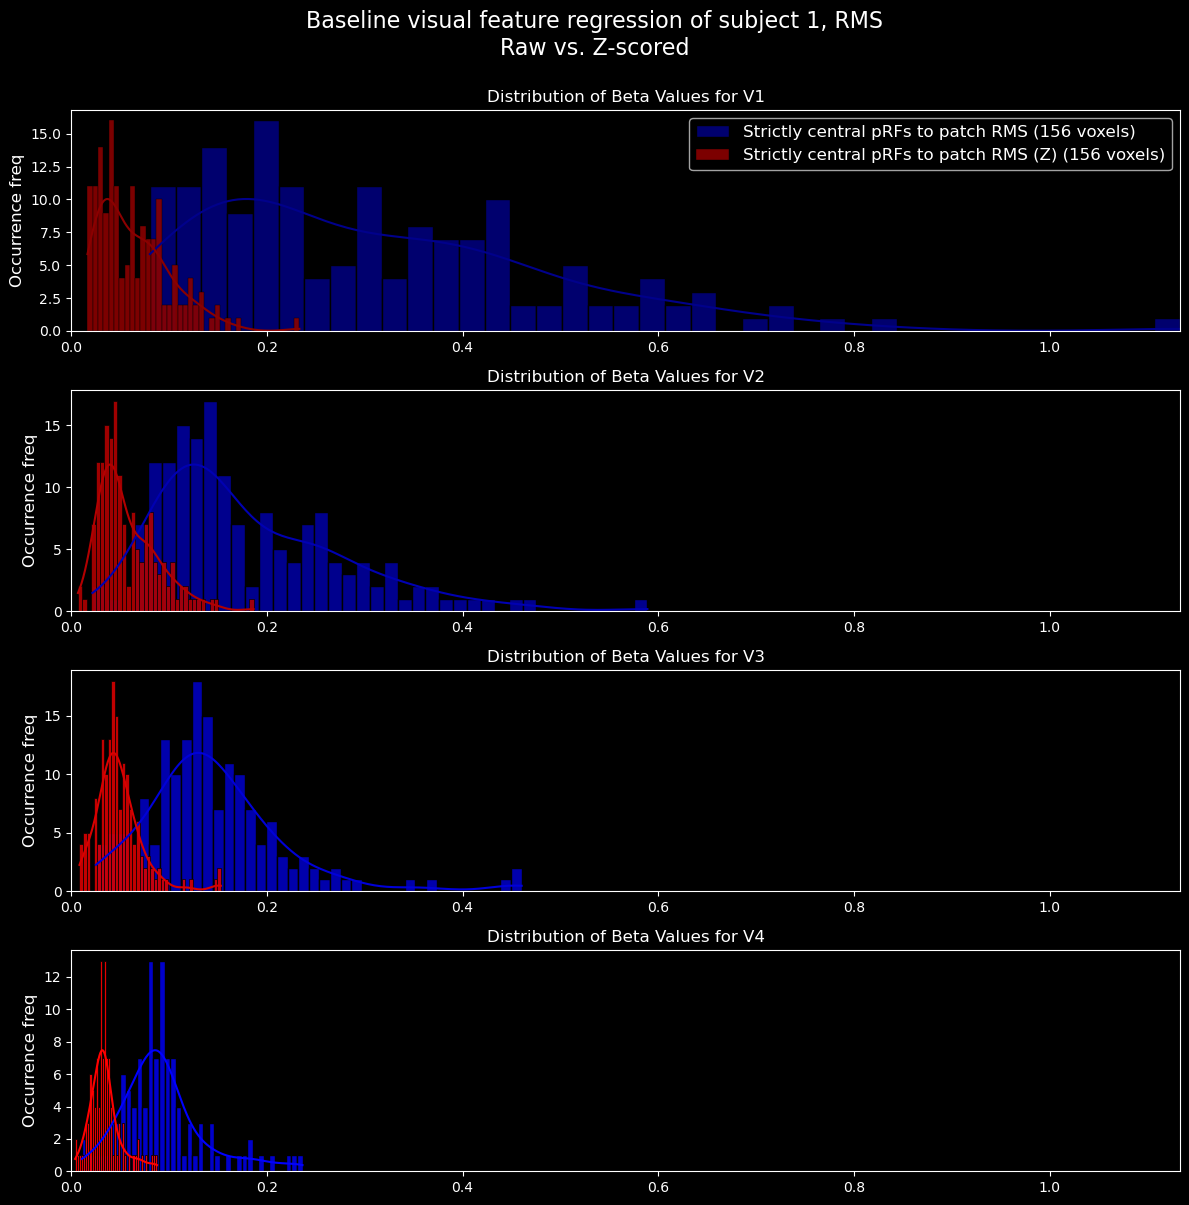

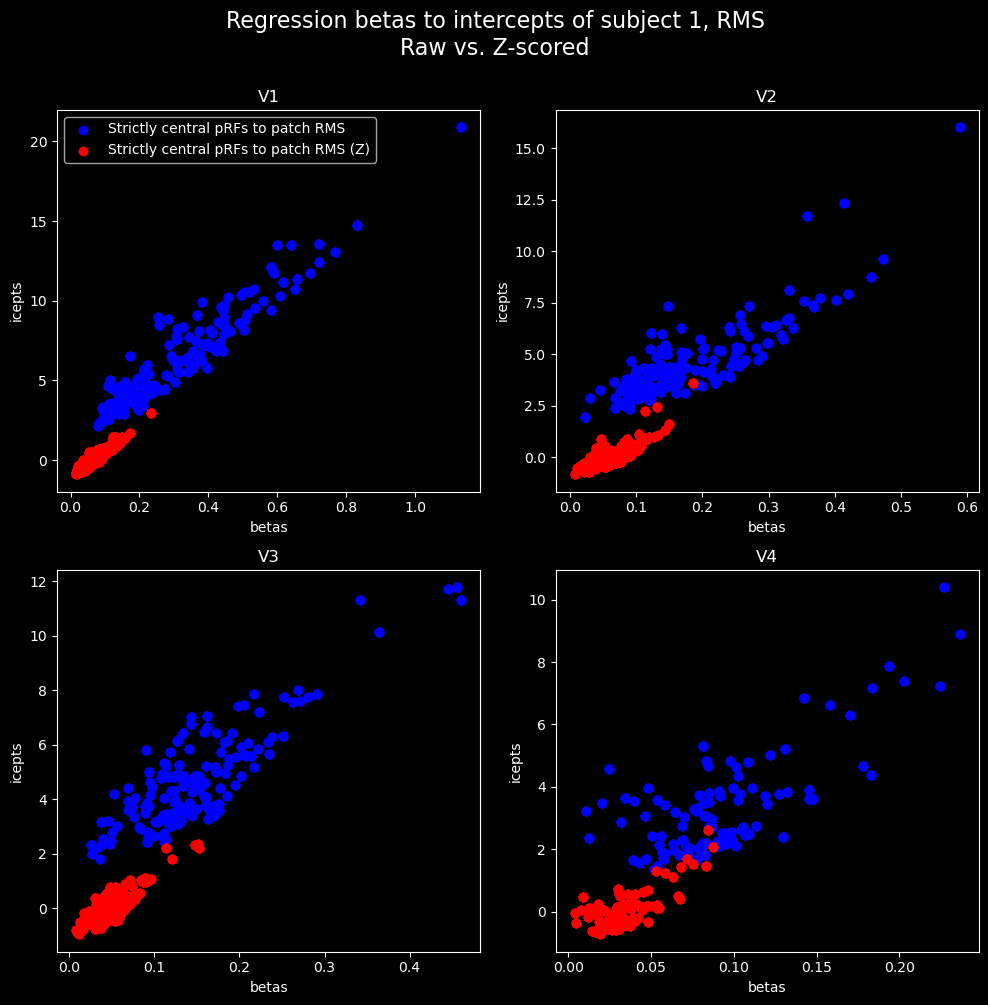

In [18]:

reg_plots(regstash['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS', comptype = 'Raw vs. Z-scored',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_z['centralprfs']['loose']['rel'], 
                           dictdescrip2 = 'Strictly central pRFs to patch RMS (Z)', beta_hist = True, beta_icept = True)

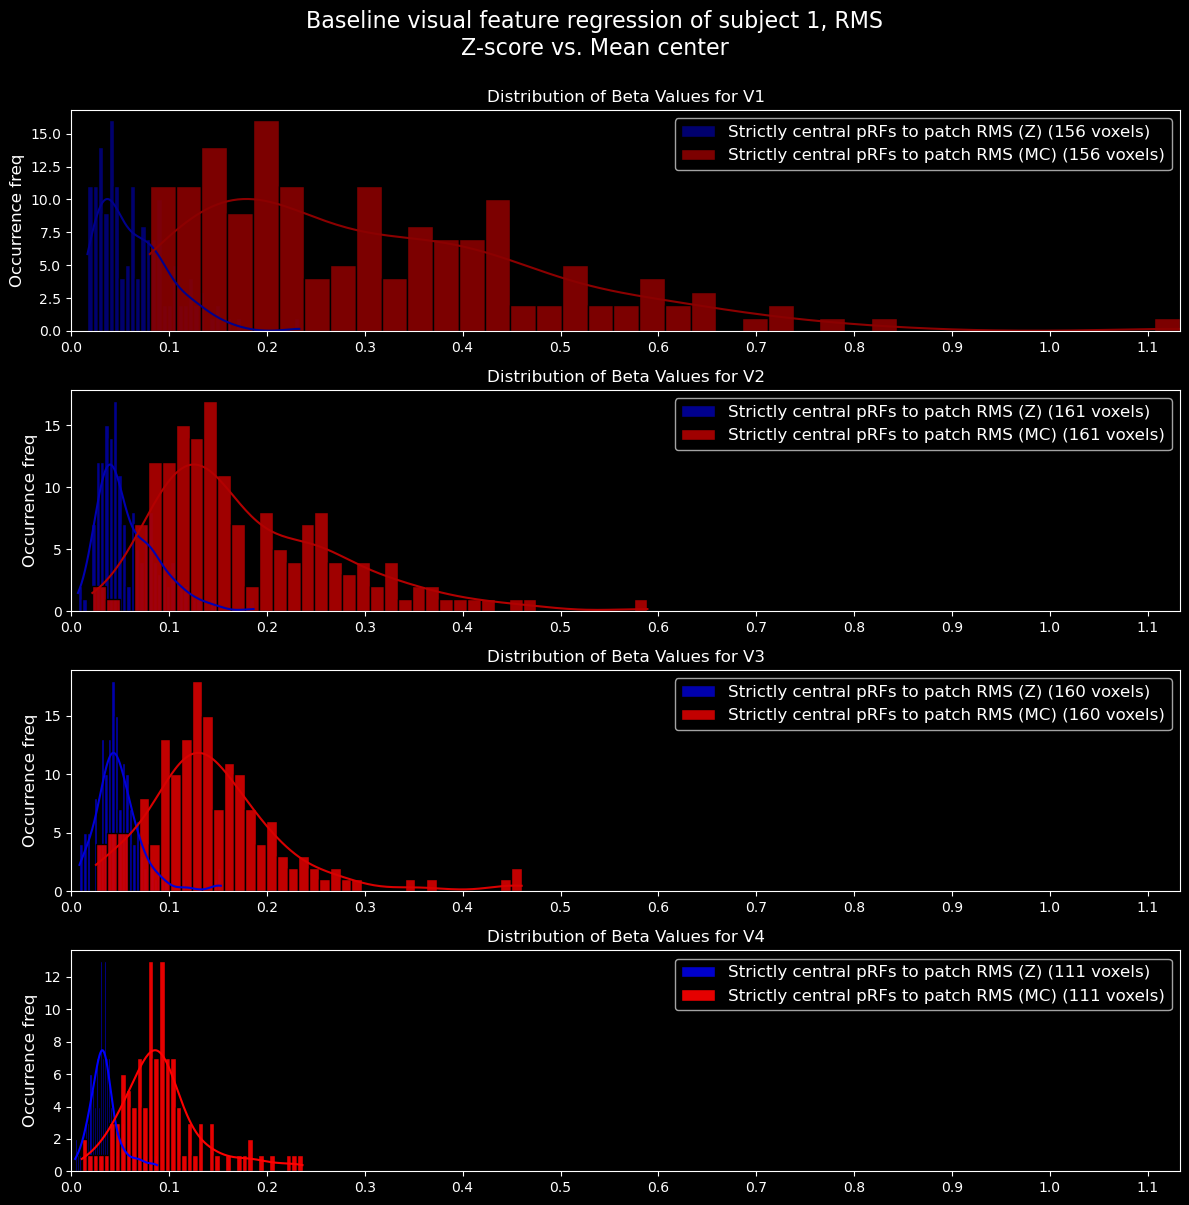

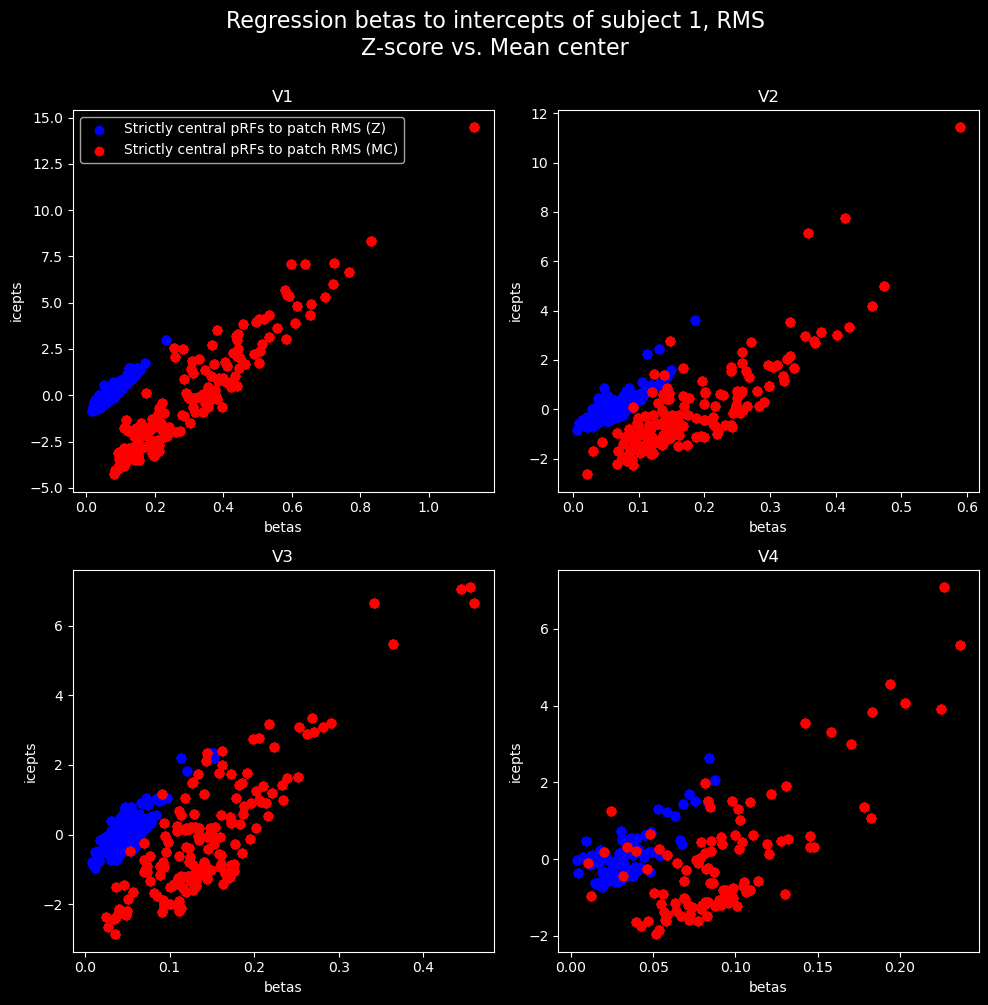

In [18]:

reg_plots(regstash_z['centralprfs']['loose']['rel'], dictdescrip1 = 'Strictly central pRFs to patch RMS (Z)', comptype = 'Z-score vs. Mean center',
                           icept_correct = 'n', feat_type = 'RMS', comparison_reg_dict = regstash_mc['centralprfs']['loose']['rel'], 
                           dictdescrip2 = 'Strictly central pRFs to patch RMS (MC)', beta_hist = True, beta_icept = True)